In [1]:
import sys
sys.path.append('../')

from tasks import LauraTaskWrapper
from architecture import SequentialModel
from analysis_utils import load_checkpoints, import_checkpoint
from train import ping_dir

import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from tqdm import tqdm


In [2]:

def get_components(X, k=-1, center = True, return_var = False):
    # If center = True, use PCA. If not true, use SVD, i.e. consider points relative to zero, not the mean.
    if center:
        return PCA(k).fit(X).components_

    # SVD case.
    _, S, Vt = np.linalg.svd(X, full_matrices=False)
    var = S**2 
    varrat = var / np.sum(var)
    dim = np.argwhere(np.cumsum(varrat) > .95)[0,0] + 1
    if k != -1:
        Vt = Vt[:dim]
        var = var[:dim]

    if return_var:
        return dim, Vt, var
    return dim, Vt
    
def unit_vector(vector, axis = -1):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector, axis = axis, keepdims = True)

def angle_between(v1, v2, axis = -1):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1, axis)
    v2_u = unit_vector(v2, axis)
    v1t = np.moveaxis(v1_u, axis, -1)
    v2t = np.moveaxis(v2_u, axis, -1)
    dot = (v1t[..., None, :] @ v2t[..., :, None])[..., 0, 0]
    return np.arccos(np.clip(dot, -1.0, 1.0))


In [3]:
class Model(nn.Module):
    def __init__(self, input_size=7, hidden_size=100, output_size=3):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.Wout = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, h0=None):
        hidden, _ = self.rnn(x, h0)
        return self.Wout(hidden), hidden  # [B, T, 3]
    
    def analysis_mode(self, X, target, h0=None):
        # Intended for deep analysis of the GD flow:
        # Run RNN and compute losses, 
        # returning hidden, adjoints, outputs, unreduced losses, reduced loss.
        # Shapes: [B, T, H], [B, T, H], [B, T, O], [B, T, O], scalar.
        out, hidden = self.forward(X, h0)  # A list.
        hidden.retain_grad()
        loss_fn = nn.MSELoss(reduction='none')
        loss_unreduced = loss_fn(out, target)
        loss = loss_unreduced.mean()
        loss.backward()  # Perform BPTT.
        adjoint = hidden.grad  # dL/dz defn of adjoint.
        return hidden, adjoint, out, loss_unreduced, loss

# Get a GRUCell from the model above with the same parameters.
def get_cell_from_model(model):
    cell = nn.GRUCell(model.rnn.input_size, model.rnn.hidden_size).to(model.Wout.weight.device)
    cell.weight_ih.data.copy_(model.rnn.weight_ih_l0.data)
    cell.weight_hh.data.copy_(model.rnn.weight_hh_l0.data)
    cell.bias_ih.data.copy_(model.rnn.bias_ih_l0.data)
    cell.bias_hh.data.copy_(model.rnn.bias_hh_l0.data)
    return cell

## Model definition (a GRU):

In [4]:
import copy

def eval(ch):
    model.load_state_dict(import_checkpoint(ch))
    model.zero_grad()
    hidden, adjoint, out, loss_unreduced, loss = model.analysis_mode(inputs.cuda(), targets.cuda())
    W_grad = 0. #W_grad = model.W.weight.grad.cpu().numpy()
    out, hidden = out.detach().cpu().numpy(), hidden.detach().cpu().numpy()
    adjoint = adjoint.detach().cpu().numpy()
    return model, hidden, adjoint, out, W_grad, loss.item(), loss_unreduced
    
def eval_next(model):
    # Do a small GD step and rerun model.
    eta = .01
    with torch.no_grad():  # Ensure no gradient tracking
        for param in model.parameters():
            if param.grad is not None:  # Only update if gradient exists
                param -= eta * param.grad
    return model(inputs.cuda())[1].detach().cpu().numpy()

# For Re-Training the Model

<h2>For a list of training hyperparameters run 'python train.py --help' or just look in train.py</h2>

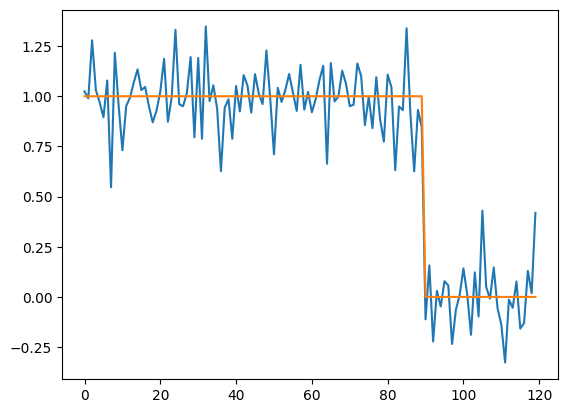

In [54]:
task  = LauraTaskWrapper('mix_multi_tasks', 200, use_noise = True, n_samples = 3000, n_spike = 20, T = 90)

inputs, targets = task()
plt.plot(inputs[0, :, 0])
plt.plot(targets[0, :, 0])
plt.show()

For training with my codebase. I found it to be quite a lot slower than using a vanilla GRU for now so disabled it:

In [37]:
# hyperparams = {
#     'prefix': 'test_mix_tasks_gru',
#     'save_freq': 100,
#     'grad_clip': 0.0001,
#     'lr': 1e-3,
#     'task_suite': 'laura',
#     'task': 'mix_multi_tasks',
#     'niters': 5000
# }

# from train import train
# train(hyperparams)

Vanilla GRU training:

100%|██████████| 5000/5000 [01:02<00:00, 80.39it/s]


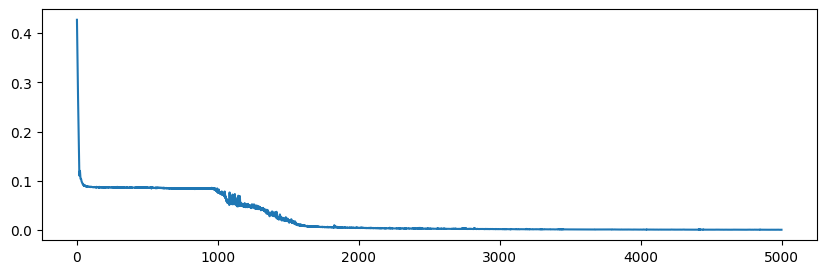

100%|██████████| 5000/5000 [01:02<00:00, 80.12it/s]


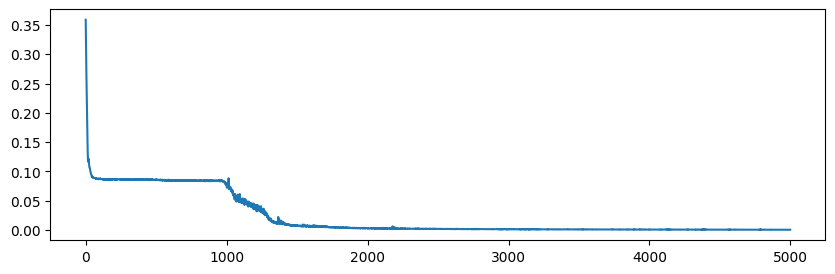

100%|██████████| 5000/5000 [00:59<00:00, 84.43it/s]


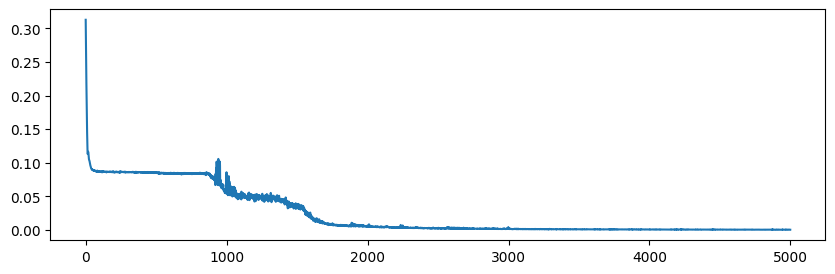

100%|██████████| 5000/5000 [00:59<00:00, 83.88it/s]


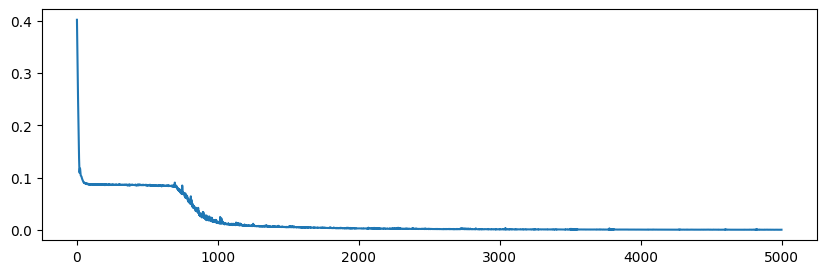

100%|██████████| 5000/5000 [00:59<00:00, 83.57it/s]


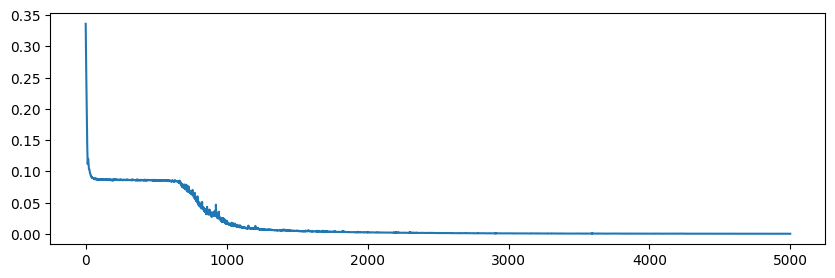

100%|██████████| 5000/5000 [00:59<00:00, 83.63it/s]


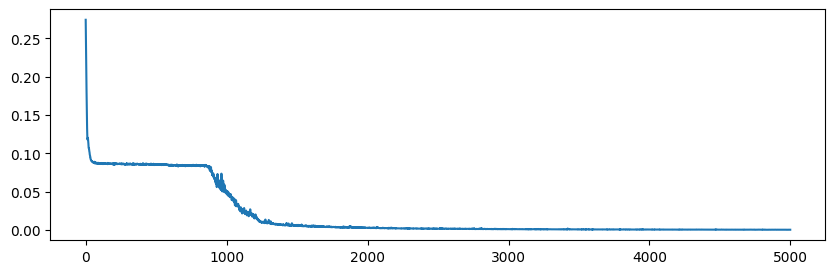

100%|██████████| 5000/5000 [00:59<00:00, 83.67it/s]


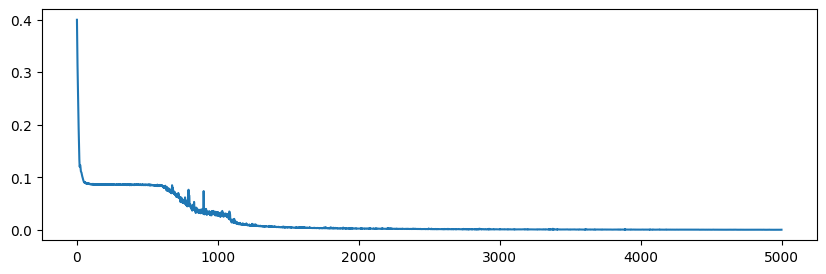

100%|██████████| 5000/5000 [00:59<00:00, 83.58it/s]


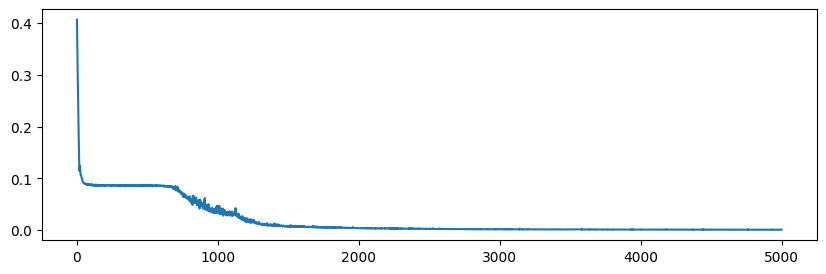

100%|██████████| 5000/5000 [01:00<00:00, 83.11it/s]


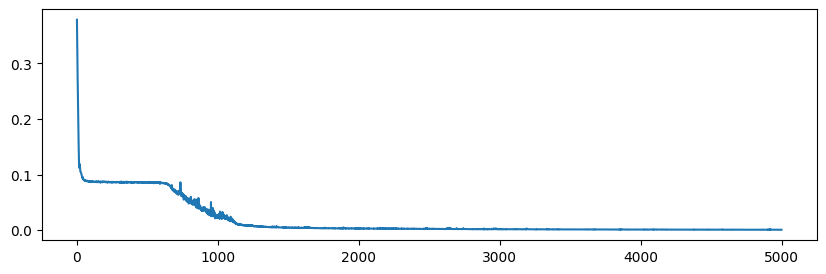

100%|██████████| 5000/5000 [00:59<00:00, 83.89it/s]


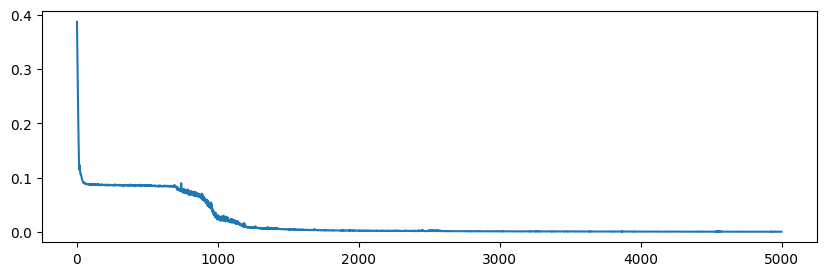

In [55]:

for repeat in range(10):
    device = 'cuda'

    # Initialize model and move to appropriate device
    model = Model().to(device)
    optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
    loss_fn = nn.MSELoss()
    losses = []

    ping_dir('mix_tasks_gru_repeated/')
    path = f'mix_tasks_gru_repeated/repeat_{repeat}/'
    ping_dir(path)
    ping_dir(f'{path}checkpoints/', clear = True)

    checkpoints = []
    for itr in tqdm(range(5000)):
        inputs, targets = task()
        inputs, targets = inputs.to(device), targets.to(device)  # Instead of .cuda()

        optim.zero_grad()
        out = model(inputs)[0]
        loss = loss_fn(out, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), .0001)
        optim.step()

        losses.append(loss.item())
        if itr % 100 == 0:
            checkpoints.append(copy.deepcopy(model.state_dict()))
            torch.save(model.state_dict(), f'{path}checkpoints/checkpoint_{itr}.pt')
            
    plt.figure(figsize = (10, 3))
    plt.plot(losses)
    plt.show()

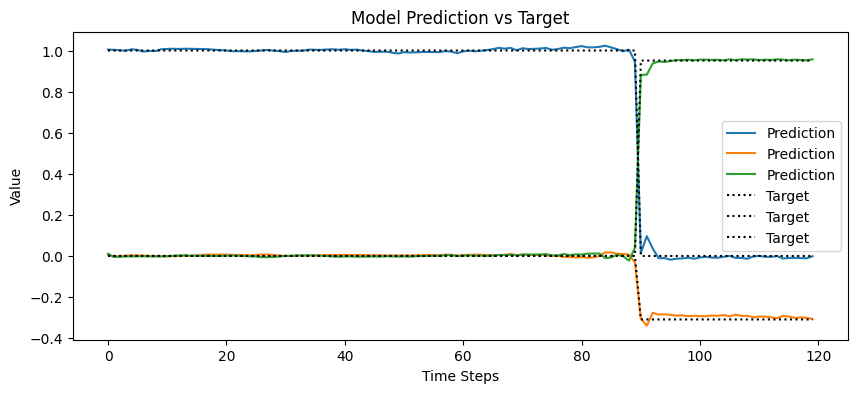

In [56]:
# Set noise standard deviation to 0
model.noise_std = 0.

# Make sure to move tensors to CPU for plotting
# This works regardless of whether the tensors are on MPS or CPU device
plt.figure(figsize=(10, 4))
plt.plot(out[0].detach().cpu().numpy(), label='Prediction')
plt.plot(targets[0].detach().cpu().numpy(),':k', label='Target')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Model Prediction vs Target')
plt.show()

# Load model and generate testing set:

In [5]:
# ch_path = 'scale_sweeps_1_10/DelayMatchSample-v0/grid_20/'
device = 'cuda'
ch_path = 'mix_tasks_gru/'
checkpoints = load_checkpoints(ch_path)[0]
checkpoints_all = list(checkpoints)
print(len(checkpoints))
checkpoints = checkpoints[::5] # Subset
model = Model().to(device)
model.load_state_dict(import_checkpoint(checkpoints[-1]))

task_test  = LauraTaskWrapper('mix_multi_tasks', 1000, use_noise = False, n_samples = 1000, n_spike = 20, T = 90)
inputs, targets = task_test()
out, hidden = model(inputs.to(device))
out, hidden = out.detach().cpu().numpy(), hidden.detach().cpu().numpy()


50


### Visualize the performance. Task code is contained in tasks.py and mix_multi_tasks.py

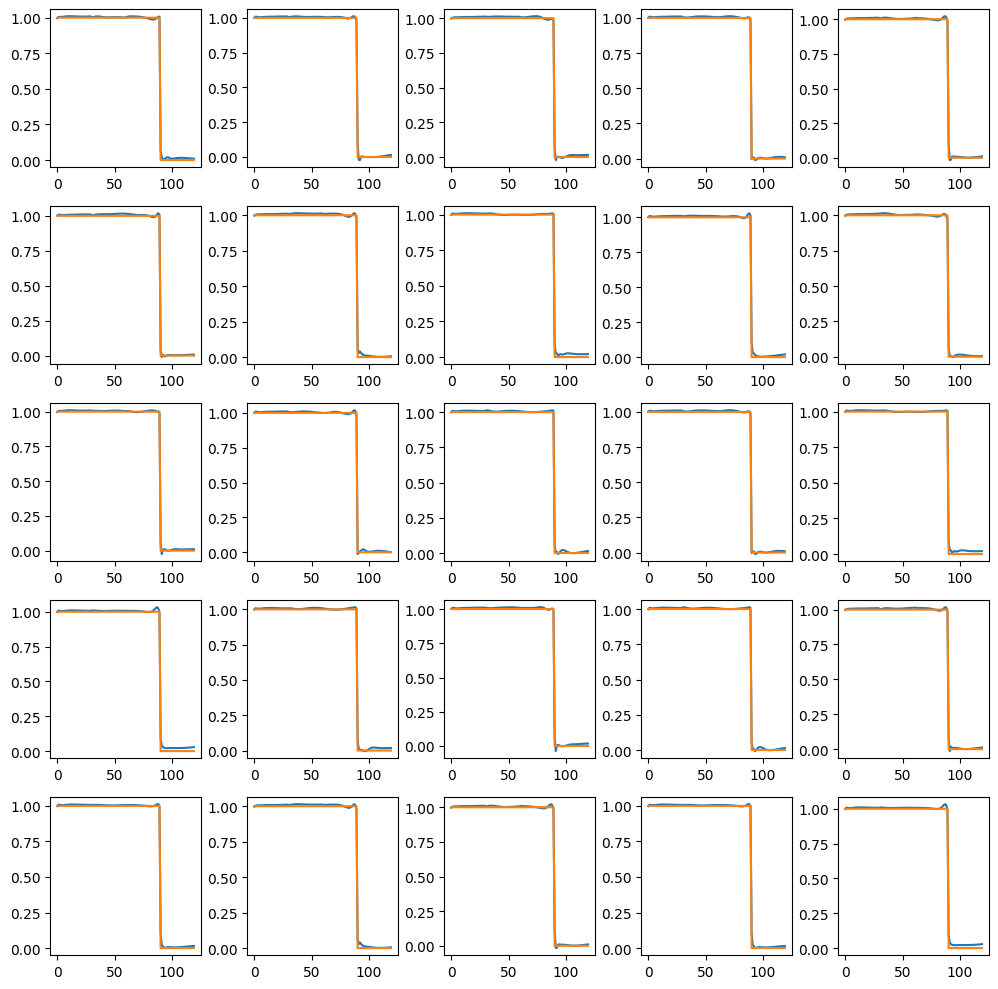

In [6]:

plt.figure(figsize = (10, 10))
for b in range(25):
    plt.subplot(5, 5, b + 1)
    plt.plot(out[b, :, 0])
    plt.plot(targets[b, :, 0])
plt.tight_layout()
plt.show()

### This code splits up data (e.g. state, adjoint, input, target) into a dict of four sets of trajectories:

In [7]:
import numpy as np
import torch  # Import torch at the module level

def get_splits(inputs):
    """Get indices for each task type, supporting both flag-based and one-hot encodings"""
    names = ['mem_pro', 'mem_anti', 'del_pro', 'del_anti']
    
    # Check input dimension to determine encoding method
    input_dim = inputs.shape[2]
    
    # Create masks for each task type based on one-hot encoding
    masks = [
        inputs[:, 0, 3] > 0.5,  # mem_pro (one-hot position 3)
        inputs[:, 0, 4] > 0.5,  # mem_anti (one-hot position 4)
        inputs[:, 0, 5] > 0.5,  # del_pro (one-hot position 5)
        inputs[:, 0, 6] > 0.5   # del_anti (one-hot position 6)
        ]
    
    # Get indices for each mask
    inds_tasks = []
    for mask in masks:
        indices = np.where(mask)[0]
        inds_tasks.append(indices)
    
    return {name: inds for name, inds in zip(names, inds_tasks)}
    
def split_data(splits, data):
    """Split data according to the provided indices"""
    result = {}
    
    # Check if data is a PyTorch tensor
    is_torch = isinstance(data, torch.Tensor)
    
    for name, split_indices in splits.items():
        # Handle various types of indices
        if isinstance(split_indices, np.ndarray) and split_indices.size > 0:
            # Convert to PyTorch tensor if needed
            if is_torch:
                # Convert NumPy indices to PyTorch tensor
                indices_tensor = torch.from_numpy(split_indices).long()
                # Move to same device as data
                indices_tensor = indices_tensor.to(data.device)
                result[name] = data[indices_tensor]
            else:
                # NumPy indexing
                result[name] = data[split_indices]
        else:
            # For empty arrays or non-array indices
            if is_torch:
                # PyTorch tensor - create empty tensor with same properties
                result[name] = torch.zeros((0,) + tuple(data.shape[1:]), 
                                         dtype=data.dtype, 
                                         device=data.device)
            else:
                # NumPy array - create empty array with same shape
                result[name] = np.zeros((0,) + data.shape[1:], dtype=np.float32)
    
    return result

In [8]:
splits = get_splits(inputs)
hidden_split = split_data(splits, hidden)
input_split = split_data(splits, inputs)
target_split = split_data(splits, targets)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import rgb2hex
from matplotlib.gridspec import GridSpec

def find_segments(inputs, trial_idx=0):
    """Find boundaries where input values change in a piecewise constant signal
    
    Args:
        inputs: Array of shape (batch, time, features)
        trial_idx: Which trial to analyze (default: 0)
    
    Returns:
        segments: List of (start, end) tuples for each segment
    """
    # Get the inputs for a single trial
    trial_inputs = inputs[trial_idx, :, :]
    
    # Find where any input feature changes value
    changes = np.where(np.abs(np.diff(trial_inputs, axis=0)).sum(axis=1) > 0)[0]
    
    # Add start and end points to create segment boundaries
    boundaries = [0] + [i+1 for i in changes] + [trial_inputs.shape[0]]
    
    # Create segments as (start, end) tuples
    segments = [(boundaries[i], boundaries[i+1]) for i in range(len(boundaries)-1)]
    
    return segments

def get_segment_colors(cmap_name, num_segments):
    """Generate segment colors from a colormap, avoiding very light colors
    
    Args:
        cmap_name: Name of the matplotlib colormap
        num_segments: Number of segments to generate colors for
    
    Returns:
        List of hex color strings
    """
    cmap = plt.colormaps[cmap_name]
    # Skip the first 30% of the colormap to avoid very light colors
    min_value = 0.3
    
    if num_segments == 1:
        return [rgb2hex(cmap(0.7)[:3])]
    
    colors = []
    for i in range(num_segments):
        # Scale position from min_value to 1.0
        position = min_value + (i / (num_segments - 1)) * (1.0 - min_value)
        colors.append(rgb2hex(cmap(position)[:3]))
    
    return colors

def plot_task_segments(hidden_split, input_split, data_for_pca=None, nplot=5, figsize=(18, 15)):
    """Plot PCA of hidden states for each task, colored by input segments
    
    Args:
        hidden_split: Dictionary mapping task names to hidden state arrays (batch, time, features)
        input_split: Dictionary mapping task names to input arrays (batch, time, features)
        data_for_pca: Optional data to fit PCA (defaults to all hidden states combined)
        nplot: Number of trials to plot per task
        figsize: Figure size
        
    Returns:
        Dictionary of results for each task
    """
    task_names = list(hidden_split.keys())
    
    # Fit PCA to all data if not provided
    if data_for_pca is None:
        all_hidden = np.vstack([h.reshape(-1, h.shape[-1]) for h in hidden_split.values()])
        pca = PCA(3).fit(all_hidden)
    else:
        pca = PCA(3).fit(data_for_pca)
    
    # Set up figure with custom grid layout
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(4, 2, width_ratios=[3, 1])  # 3D plot gets more width
    
    results = {}
    
    # Plot each task
    for i, task_name in enumerate(task_names):
        hidden = hidden_split[task_name]
        inputs = input_split[task_name]
        
        # Find segments and generate colors
        segments = find_segments(inputs)
        segment_colors = get_segment_colors('viridis', len(segments))
        
        # Project hidden states using PCA
        proj = pca.transform(hidden.reshape(-1, hidden.shape[-1])).reshape(*hidden.shape[:-1], 3)
        
        # Create 3D plot for hidden states
        ax1 = fig.add_subplot(gs[i, 0], projection='3d')
        
        # Plot each trial and segment with appropriate colors
        for trial in range(min(nplot, hidden.shape[0])):
            for j, ((start, end), color) in enumerate(zip(segments, segment_colors)):
                ax1.plot(
                    proj[trial, start:end+1, 0],
                    proj[trial, start:end+1, 1],
                    proj[trial, start:end+1, 2],
                    color=color,
                    alpha=0.8,
                    linewidth=2,
                    label=f"Segment {j}" if trial == 0 else ""
                )
        
        ax1.set_title(f'{task_name} - Hidden State Trajectory')
        ax1.set_xlabel('PC1')
        ax1.set_ylabel('PC2')
        ax1.set_zlabel('PC3')
        
        # Create timeseries plot for inputs
        ax2 = fig.add_subplot(gs[i, 1])
        
        # Plot input features
        for feat in range(inputs.shape[2]):
            ax2.plot(inputs[0, :, feat], label=f'Input {feat}')
        
        # Add boundaries and shading
        for (start, end), color in zip(segments, segment_colors):
            ax2.axvspan(start, end, alpha=0.2, color=color)
            if start > 0:  # Skip first boundary
                ax2.axvline(x=start, color='k', linestyle='--', alpha=0.5)
        
        ax2.set_title(f'{task_name} - Input Signal')
        ax2.set_xlabel('Time Steps')
        ax2.set_ylabel('Input Value')
        
        # Add legend for first task only
        if i == 0:
            ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Store results
        results[task_name] = {
            'pca': pca,
            'segments': segments,
            'colors': segment_colors
        }
    
    plt.tight_layout()
    return results

def plot_combined_task_segments(hidden_split, input_split, data_for_pca=None, nplot=3, figsize=(20, 12)):
    """Plot all tasks in a single 3D visualization with color-coded segments
    
    Args:
        hidden_split: Dictionary mapping task names to hidden state arrays
        input_split: Dictionary mapping task names to input arrays
        data_for_pca: Optional data to fit PCA
        nplot: Number of trials to plot per task
        figsize: Figure size
        
    Returns:
        PCA object and segments dictionary
    """
    task_names = list(hidden_split.keys())
    task_cmaps = ['Blues', 'Reds', 'Greens', 'Purples']  # One colormap per task
    
    # Fit PCA to all data if not provided
    if data_for_pca is None:
        all_hidden = np.vstack([h.reshape(-1, h.shape[-1]) for h in hidden_split.values()])
        pca = PCA(3).fit(all_hidden)
    else:
        pca = PCA(3).fit(data_for_pca)
    
    # Set up figure with custom grid layout
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 3, width_ratios=[3, 1, 1])
    
    # Create 3D plot for all tasks
    ax1 = fig.add_subplot(gs[:, 0], projection='3d')
    all_segments = {}

    # Plot all tasks in the 3D plot
    combined_plot(hidden_split, input_split, data_for_pca, nplot = nplot)
    
    # Create small input plots for each task
    for i, task_name in enumerate(task_names):
        row = i // 2
        col = (i % 2) + 1
        ax = fig.add_subplot(gs[row, col])
        
        inputs = input_split[task_name]
        segments = all_segments[task_name]
        segment_colors = get_segment_colors(task_cmaps[i], len(segments))
        
        # Plot input features
        for feat in range(inputs.shape[2]):
            ax.plot(inputs[0, :, feat], label=f'Input {feat}')
        
        # Add boundaries and shading
        for (start, end), color in zip(segments, segment_colors):
            ax.axvspan(start, end, alpha=0.2, color=color)
            if start > 0:  # Skip first boundary
                ax.axvline(x=start, color='k', linestyle='--', alpha=0.5)
        
        ax.set_title(f'{task_name} - Input Signal')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Input Value')
        
        # Add legend for first task only
        if i == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    return pca, all_segments


def combined_plot(hidden_split, input_split, data_for_pca=None, nplot = 3):
    """Plot all tasks in a single 3D visualization with color-coded segments
    
    Args:
        hidden_split: Dictionary mapping task names to hidden state arrays
        input_split: Dictionary mapping task names to input arrays
        data_for_pca: Optional data to fit PCA
        nplot: Number of trials to plot per task
        figsize: Figure size
        
    Returns:
        PCA object and segments dictionary
    """
    task_names = list(hidden_split.keys())
    task_cmaps = ['Blues', 'Reds', 'Greens', 'Purples']  # One colormap per task
    
    # Fit PCA to all data if not provided
    if data_for_pca is None:
        all_hidden = np.vstack([h.reshape(-1, h.shape[-1]) for h in hidden_split.values()])
        pca = PCA(3).fit(all_hidden)
    else:
        pca = PCA(3).fit(data_for_pca)
    
    ax1 = plt.gca()
    all_segments = {}
    
    # Plot all tasks in the 3D plot
    for i, (task_name, cmap_name) in enumerate(zip(task_names, task_cmaps)):
        hidden = hidden_split[task_name]
        inputs = input_split[task_name]
        
        # Project hidden states
        proj = pca.transform(hidden.reshape(-1, hidden.shape[-1])).reshape(*hidden.shape[:-1], 3)
        
        # Find segments and generate colors
        segments = find_segments(inputs)
        all_segments[task_name] = segments
        segment_colors = get_segment_colors(cmap_name, len(segments))
        
        # Plot each trial and segment
        for trial in range(min(nplot, hidden.shape[0])):
            for j, ((start, end), color) in enumerate(zip(segments, segment_colors)):
                label = f"{task_name} - Segment {j}" if trial == 0 else ""
                ax1.plot(
                    proj[trial, start:end+1, 0],
                    proj[trial, start:end+1, 1],
                    proj[trial, start:end+1, 2],
                    color=color,
                    alpha=0.8,
                    linewidth=2,
                    label=label
                )
    
    ax1.set_title('Combined Hidden State Trajectories')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    # ax1.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    
    
    plt.tight_layout()
    return pca, all_segments

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


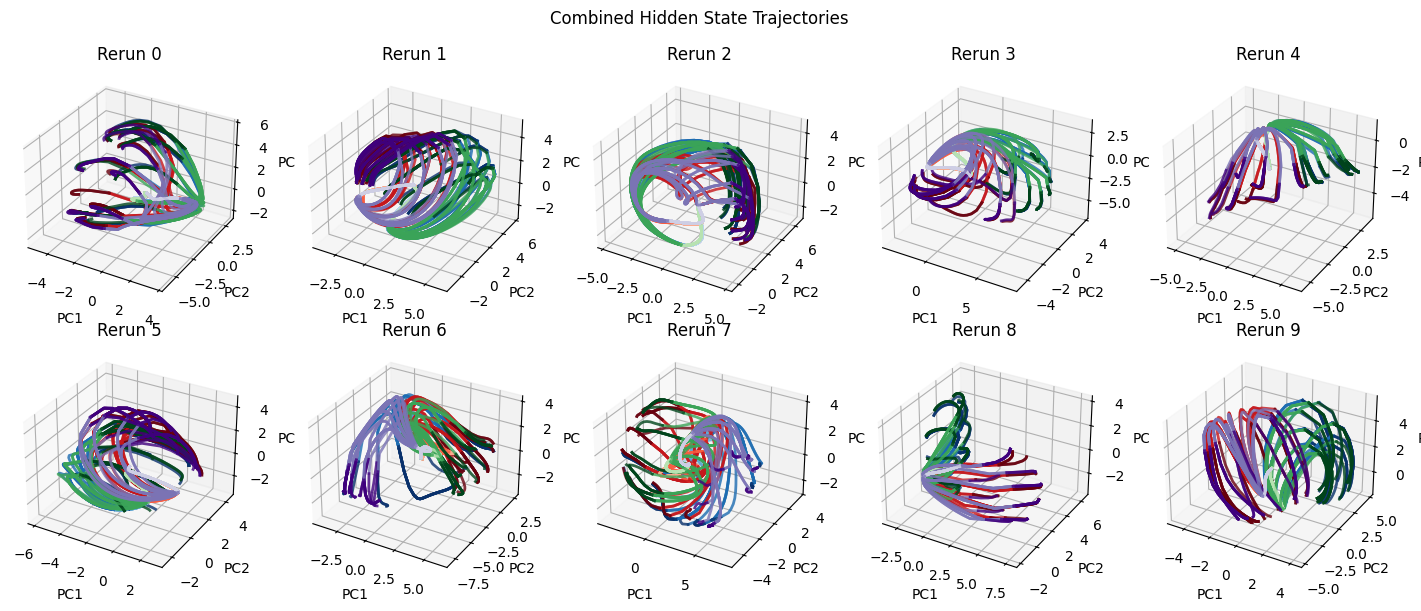

In [13]:
task_test  = LauraTaskWrapper('mix_multi_tasks', 100, use_noise = False, n_samples = 100, n_spike = 20, T = 90)
inputs, targets = task_test()

plt.figure(figsize = (15, 6))
for repeat in tqdm(range(10)):
    path = f'mix_tasks_gru_repeated/repeat_{repeat}/'
    checkpoints = load_checkpoints(path)[0]
    checkpoints = list(checkpoints)
    model = Model().to(device)
    model.load_state_dict(import_checkpoint(checkpoints[-1]))

    out, hidden = model(inputs.to(device))
    out, hidden = out.detach().cpu().numpy(), hidden.detach().cpu().numpy()

    # Using your data splits
    splits = get_splits(inputs)
    hidden_split = split_data(splits, hidden)
    input_split = split_data(splits, inputs)
    
    # # Individual task plots
    # results = plot_task_segments(hidden_split, input_split, nplot=30)
    
    # Combined visualization
    # pca, segments = plot_combined_task_segments(hidden_split, input_split, nplot=30)
    plt.subplot(2, 5, repeat + 1, projection = '3d')
    combined_plot(hidden_split, input_split, nplot = 30)
    plt.suptitle(plt.gca().get_title())
    plt.title(f'Rerun {repeat}')
plt.show()

In [25]:
def get_rayleigh_matrix(ops, target_split):
    coefs = np.zeros((4,4))
    for i, task1 in enumerate(ops.keys()):
        for j, task2 in enumerate(ops.keys()):
            coefs[i,j] = ops[task1].rayleigh_coef(target_split[task2])
    return coefs

def plot_rayleigh_matrix(coefs, **kwargs):
    im = plt.imshow(coefs, **kwargs)
    plt.xticks(list(range(4)), list(input_split.keys()), rotation = 45)
    plt.yticks(list(range(4)), list(input_split.keys()), rotation = 45)
    return im

In [26]:
task_test  = LauraTaskWrapper('mix_multi_tasks', 500, use_noise = False, n_samples = 500, n_spike = 20, T = 90)
inputs, targets = task_test()

coefs_all = []
for repeat in tqdm(range(10)):
    path = f'mix_tasks_gru_repeated/repeat_{repeat}/'
    checkpoints = load_checkpoints(path)[0]
    checkpoints = list(checkpoints)

    model, hidden, adjoint, out = eval(checkpoints[-1])[:4]

    # Using your data splits
    splits = get_splits(inputs)
    hidden_split = split_data(splits, hidden)
    input_split = split_data(splits, inputs)
    target_split = split_data(splits, targets)
    adjoint_split = split_data(splits, adjoint)

    # Define the operator. 
    from analysis.parameter_op import ParameterOperator
    from analysis.propagation_op import PropagatorOperator
    from analysis.op_common import ComposedOperator
    composed_op_fact = lambda inp_sp, hidd_sp: ComposedOperator(PropagatorOperator(get_cell_from_model(model), inp_sp), ParameterOperator([inp_sp, hidd_sp]))
    ops = {key : composed_op_fact(inp_sp, hidd_sp) for (key, inp_sp), hidd_sp in zip(input_split.items(), hidden_split.values())} 
    coefs_all.append(get_rayleigh_matrix(ops, {key: 1e-4 * val for key, val in adjoint_split.items()}))

coefs_all = np.stack(coefs_all)
vmin, vmax = coefs_all.min(), coefs_all.max()

100%|██████████| 10/10 [00:47<00:00,  4.77s/it]


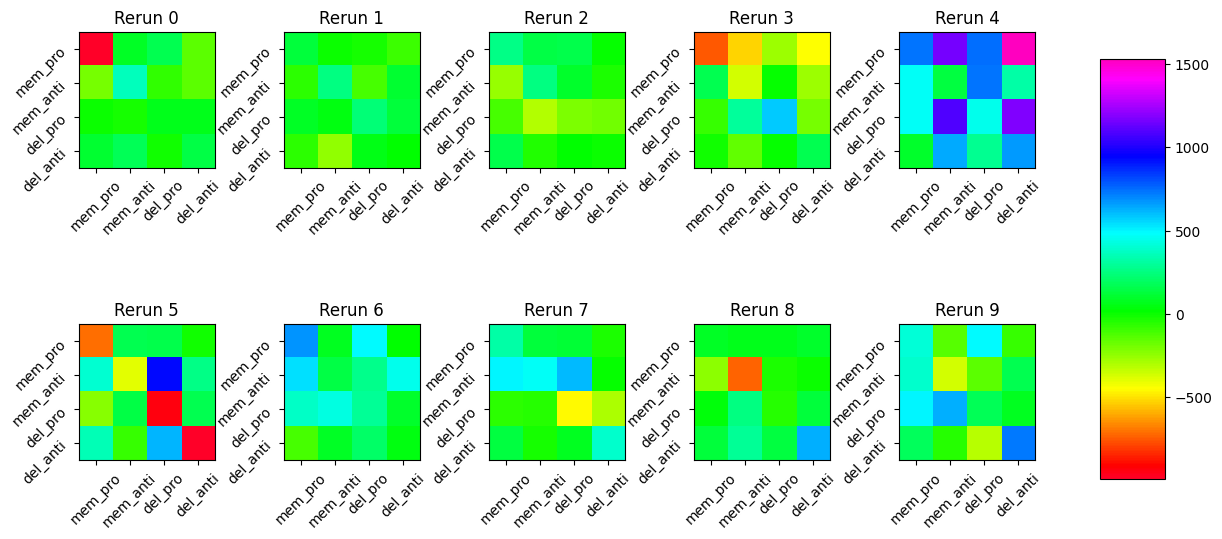

In [27]:
vmin, vmax = coefs_all.min(), coefs_all.max()

plt.figure(figsize = (13, 6))
for repeat, coefs in enumerate(coefs_all):
    plt.subplot(2, 5, repeat + 1)
    im = plot_rayleigh_matrix(coefs, vmin = vmin, vmax = vmax, cmap = 'gist_rainbow')
    plt.title(f'Rerun {repeat}')

plt.tight_layout()


plt.gcf().subplots_adjust(right=0.8)
cbar_ax = plt.gcf().add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, cax=cbar_ax)

plt.show()

In [28]:
task_test  = LauraTaskWrapper('mix_multi_tasks', 500, use_noise = False, n_samples = 500, n_spike = 20, T = 90)
inputs, targets = task_test()

coefs_all = []
for repeat in tqdm(range(10)):
    path = f'mix_tasks_gru_repeated/repeat_{repeat}/'
    checkpoints = load_checkpoints(path)[0]
    checkpoints = list(checkpoints)

    model, hidden, adjoint, out = eval(checkpoints[0])[:4]

    # Using your data splits
    splits = get_splits(inputs)
    hidden_split = split_data(splits, hidden)
    input_split = split_data(splits, inputs)
    target_split = split_data(splits, targets)
    adjoint_split = split_data(splits, adjoint)

    # Define the operator. 
    from analysis.parameter_op import ParameterOperator
    from analysis.propagation_op import PropagatorOperator
    from analysis.op_common import ComposedOperator
    composed_op_fact = lambda inp_sp, hidd_sp: ComposedOperator(PropagatorOperator(get_cell_from_model(model), inp_sp), ParameterOperator([inp_sp, hidd_sp]))
    ops = {key : composed_op_fact(inp_sp, hidd_sp) for (key, inp_sp), hidd_sp in zip(input_split.items(), hidden_split.values())} 
    coefs_all.append(get_rayleigh_matrix(ops, {key: 1e-4 * val for key, val in adjoint_split.items()}))

coefs_all = np.stack(coefs_all)
vmin, vmax = coefs_all.min(), coefs_all.max()

100%|██████████| 10/10 [00:46<00:00,  4.68s/it]


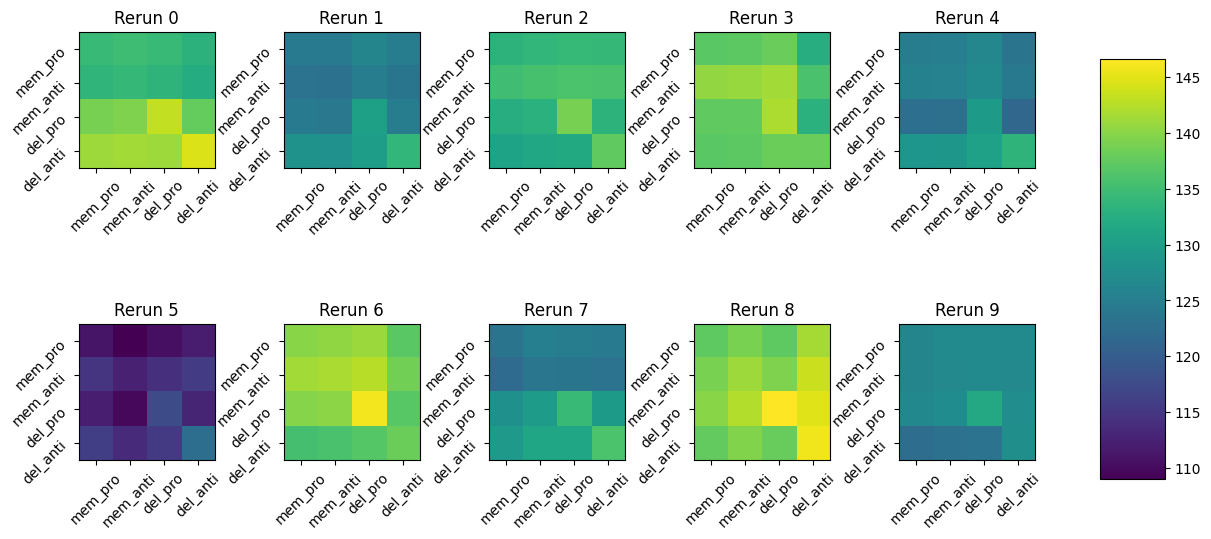

In [34]:
vmin, vmax = coefs_all.min(), coefs_all.max()

plt.figure(figsize = (13, 6))
for repeat, coefs in enumerate(coefs_all):
    plt.subplot(2, 5, repeat + 1)
    im = plot_rayleigh_matrix(coefs, vmin = vmin, vmax = vmax, cmap = 'viridis')
    plt.title(f'Rerun {repeat}')

plt.tight_layout()

plt.gcf().subplots_adjust(right=0.8)
cbar_ax = plt.gcf().add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, cax=cbar_ax)

plt.show()

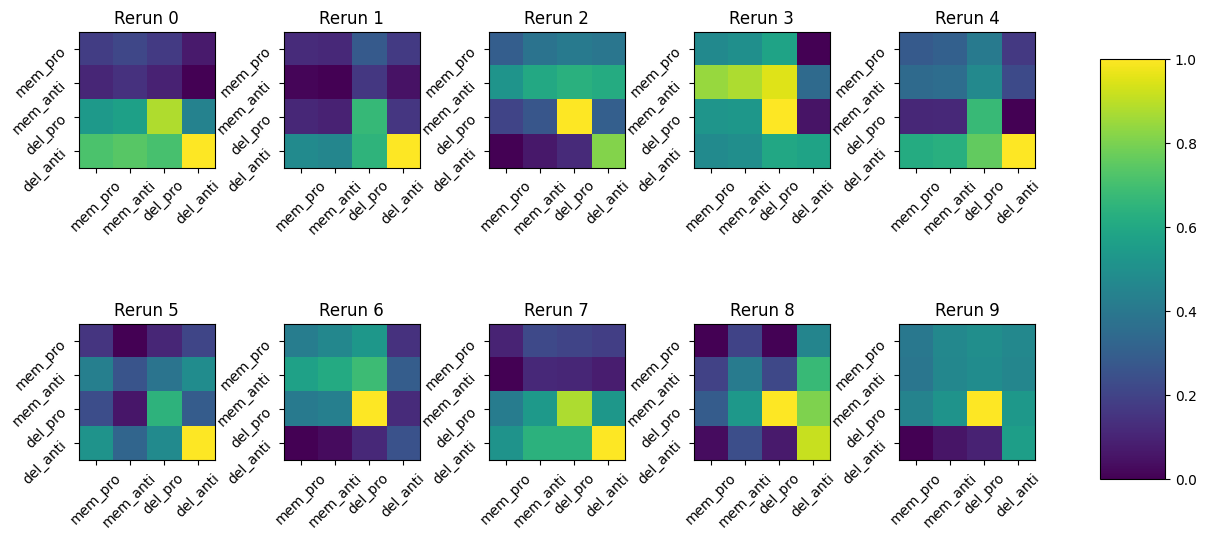

In [36]:
vmin, vmax = coefs_all.min(), coefs_all.max()

plt.figure(figsize = (13, 6))
for repeat, coefs in enumerate(coefs_all):
    plt.subplot(2, 5, repeat + 1)
    im = plot_rayleigh_matrix((coefs - coefs.min()) / (coefs.max() - coefs.min()), cmap = 'viridis')
    plt.title(f'Rerun {repeat}')

plt.tight_layout()

plt.gcf().subplots_adjust(right=0.8)
cbar_ax = plt.gcf().add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, cax=cbar_ax)

plt.show()

In [32]:
task_test  = LauraTaskWrapper('mix_multi_tasks', 500, use_noise = False, n_samples = 500, n_spike = 20, T = 90)
inputs, targets = task_test()

coefs_all = []
for repeat in tqdm(range(10)):
    path = f'mix_tasks_gru_repeated/repeat_{repeat}/'
    checkpoints = load_checkpoints(path)[0]
    checkpoints = list(checkpoints)

    model, hidden, adjoint, out = eval(checkpoints[0])[:4]

    # Using your data splits
    splits = get_splits(inputs)
    hidden_split = split_data(splits, hidden)
    input_split = split_data(splits, inputs)
    target_split = split_data(splits, targets)
    adjoint_split = split_data(splits, adjoint)

    # Define the operator. 
    from analysis.parameter_op import ParameterOperator
    from analysis.propagation_op import PropagatorOperator
    from analysis.op_common import ComposedOperator
    composed_op_fact = lambda inp_sp, hidd_sp: ParameterOperator([inp_sp, hidd_sp])
    ops = {key : composed_op_fact(inp_sp, hidd_sp) for (key, inp_sp), hidd_sp in zip(input_split.items(), hidden_split.values())} 
    coefs_all.append(get_rayleigh_matrix(ops, {key: 1e-4 * val for key, val in adjoint_split.items()}))

coefs_all = np.stack(coefs_all)
vmin, vmax = coefs_all.min(), coefs_all.max()

100%|██████████| 10/10 [00:39<00:00,  3.93s/it]


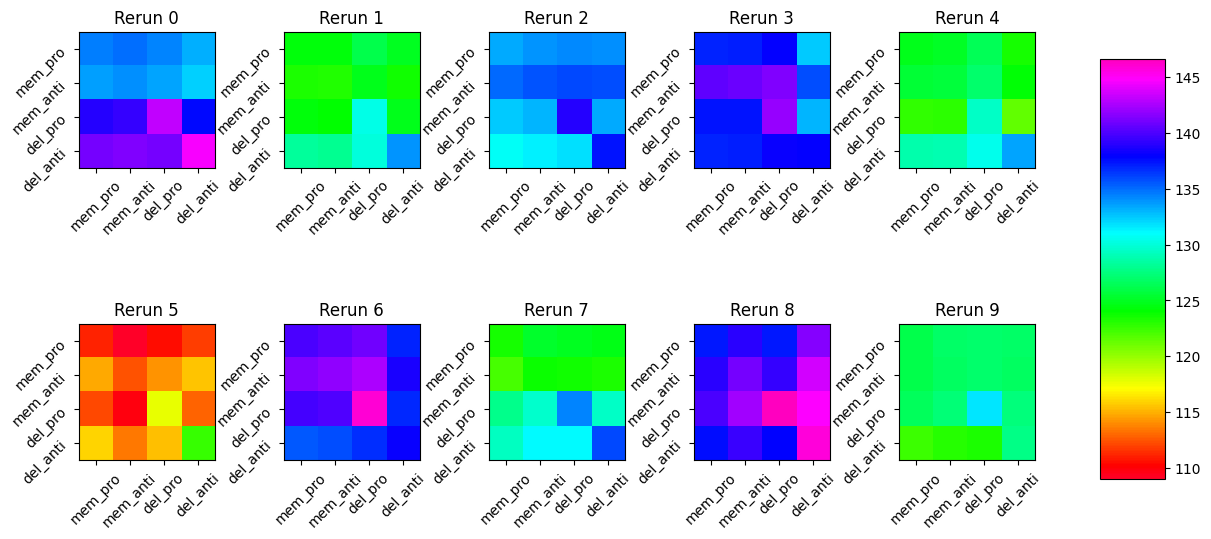

In [33]:
vmin, vmax = coefs_all.min(), coefs_all.max()

plt.figure(figsize = (13, 6))
for repeat, coefs in enumerate(coefs_all):
    plt.subplot(2, 5, repeat + 1)
    im = plot_rayleigh_matrix(coefs, vmin = vmin, vmax = vmax, cmap = 'gist_rainbow')
    plt.title(f'Rerun {repeat}')

plt.tight_layout()

plt.gcf().subplots_adjust(right=0.8)
cbar_ax = plt.gcf().add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, cax=cbar_ax)

plt.show()

In [239]:
# Get task data
inputs, targets = task_wrapper()

# Create task splits
splits = get_splits(inputs)
input_split = split_data(splits, inputs)

# Find task segments/periods for each task type
task_segments = {}
for task_name, task_inputs in input_split.items():
    if task_inputs.shape[0] > 0:  # Only if we have examples
        segments = find_segments(task_inputs)
        task_segments[task_name] = segments
        print(f"{task_name} segments: {segments}")

# Now compute adjoints for each task type
adjoints_by_task = {}
hiddens_by_task = {}
inputs_by_task = {}
targets_by_task = {}

# For each task type
for task_name, task_inputs in input_split.items():
    print(f"Processing {task_name}...")
    
    # Select a subset of examples
    n_examples = min(20, task_inputs.shape[0])
    
    if n_examples > 0:
        inputs_by_task[task_name] = task_inputs[:n_examples].to(device)
        targets_by_task[task_name] = split_data(splits, targets)[task_name][:n_examples].to(device)
        
        # Compute hidden states and adjoints
        hiddens, adjoints = [], []
        for i in range(n_examples):
            hidden, adjoint, _, _, _ = model.analysis_mode(
                inputs_by_task[task_name][i:i+1], 
                targets_by_task[task_name][i:i+1]
            )
            hiddens.append(hidden.cpu())
            adjoints.append(adjoint.cpu())
        
        # Store results
        hiddens_by_task[task_name] = torch.cat(hiddens, dim=0)
        adjoints_by_task[task_name] = torch.cat(adjoints, dim=0)

mem_pro segments: [(0, np.int64(30)), (np.int64(30), np.int64(60)), (np.int64(60), np.int64(90)), (np.int64(90), 120)]
mem_anti segments: [(0, np.int64(30)), (np.int64(30), np.int64(60)), (np.int64(60), np.int64(90)), (np.int64(90), 120)]
del_pro segments: [(0, np.int64(30)), (np.int64(30), np.int64(90)), (np.int64(90), 120)]
del_anti segments: [(0, np.int64(30)), (np.int64(30), np.int64(90)), (np.int64(90), 120)]
Processing mem_pro...
Processing mem_anti...
Processing del_pro...
Processing del_anti...


In [240]:
np.shape(inputs_by_task[task_name])

torch.Size([20, 120, 7])

In [241]:
# We already have the segments for each task type
mem_pro_segments = task_segments['mem_pro']
mem_anti_segments = task_segments['mem_anti']
del_pro_segments = task_segments['del_pro']
del_anti_segments = task_segments['del_anti']

# Extract stimulus onset period (second segment for all tasks)
stimulus_onset = {
    'mem_pro': mem_pro_segments[1][0],
    'mem_anti': mem_anti_segments[1][0],
    'del_pro': del_pro_segments[1][0],
    'del_anti': del_anti_segments[1][0],
    'title' : 'Stimulus'
}

# Extract stimulus onset period (second segment for all tasks)
response_onset = {
    'mem_pro': mem_pro_segments[-1][0],
    'mem_anti': mem_anti_segments[-1][0],
    'del_pro': del_pro_segments[-1][0],
    'del_anti': del_anti_segments[-1][0],
    'title' : 'Response'
}

# Use a window of the first 10 timesteps after stimulus onset
stimulus_window = 10

# Create PCA from all hidden states - DETACH before converting to numpy
all_hiddens = torch.cat([h.reshape(-1, h.shape[-1]) for h in hiddens_by_task.values()])
all_hiddens_np = all_hiddens.detach().numpy()
pca = PCA(n_components=2)
pca.fit(all_hiddens_np)

PCA(n_components=2)

In [258]:
norm = plt.Normalize(0, .2)

In [259]:
norm(.5)

np.float64(2.5)

In [247]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# For generating color angles from input/target data
def calculate_color_angles(data_by_task):
    """
    Calculate angular values from the input or target data for coloring.
    
    Parameters:
    -----------
    data_by_task : dict
        Dictionary mapping task names to data tensors
        
    Returns:
    --------
    dict : Dictionary mapping task names to arrays of angular values
    """
    colors_by_task = {}
    for task_name, data in data_by_task.items():
        # First move data to CPU if it's on a device like MPS or GPU
        if hasattr(data, 'device') and str(data.device) != 'cpu':
            data_cpu = data.cpu()
        else:
            data_cpu = data
            
        # Convert to numpy for calculation
        if hasattr(data_cpu, 'numpy'):
            data_np = data_cpu.numpy()
        else:
            data_np = data_cpu
            
        # Use numpy's atan2 (not math.atan2) for array operations
        # Assuming data has shape [trials, timesteps, features]
        # and we want to use the values at timestep 40
        print(np.shape(data_np))
        y = np.sin(data_np[:, 40, 2])
        x = np.cos(data_np[:, 40, 1])
        # print(x,y,np.arctan2(y, x))
        colors_by_task[task_name] = np.arctan2(y, x)
    return colors_by_task

def plot_task_arrangement_at(hiddens_by_task, onset_period, rel, 
                             color_mode='task', 
                             task_colors=None, 
                             stim_colors_by_task=None, 
                             response_colors_by_task=None):
    """
    Plot hidden state trajectories with customizable coloring options.
    
    Parameters:
    -----------
    hiddens_by_task : dict
        Dictionary mapping task names to hidden state tensors
    onset_period : dict
        Dictionary mapping task names to onset periods
    rel : int
        Relative period to plot
    color_mode : str
        One of 'task', 'stim', or 'response' to determine coloring method
    task_colors : dict, optional
        Dictionary mapping task names to colors (used when color_mode='task')
    stim_colors_by_task : dict, optional
        Dictionary mapping task names to arrays of stimulus color values
    response_colors_by_task : dict, optional
        Dictionary mapping task names to arrays of response color values
    """
    # Default task colors if not provided
    if task_colors is None:
        task_colors = {'mem_pro': 'blue', 'mem_anti': 'red', 'del_pro': 'green', 'del_anti': 'purple'}
    
    plt.figure(figsize=(8, 6))  # Increase figure size
    markers = {'mem_pro': 'o', 'mem_anti': 'o', 'del_pro': 'o', 'del_anti': 'o'}
    
    # For tracking start and end points
    start_points = {}
    end_points = {}
    
    # Create a colormap for stimulus or response colors if needed
    if color_mode in ['stim', 'response']:
        # Create a colormap for angular values (suitable for values from atan2)
        angle_cmap = plt.cm.hsv
        
        # Get the appropriate color dictionary based on mode
        color_dict = None
        if color_mode == 'stim' and stim_colors_by_task is not None:
            color_dict = stim_colors_by_task
        elif color_mode == 'response' and response_colors_by_task is not None:
            color_dict = response_colors_by_task
        
        # Determine min and max for normalization
        if color_dict:
            all_colors = []
            for task_name in hiddens_by_task.keys():
                if task_name in color_dict:
                    all_colors.extend(color_dict[task_name])
            min_color = np.min(all_colors) if all_colors else -np.pi
            max_color = np.max(all_colors) if all_colors else np.pi
        else:
            min_color, max_color = -np.pi, np.pi
            
        # Create a normalization function for the colormap
        norm = plt.Normalize(min_color, max_color)
    
    # Create a dictionary to store color values for legend
    task_to_color = {}
    
    for task_name, hidden in hiddens_by_task.items():
        onset = onset_period[task_name]
        offset = onset + rel
        inds = range(min(onset, offset), max(onset, offset))
        
        for trial_idx in range(min(10, hidden.shape[0])):  # Plot up to 10 trials per task
            # First move hidden to CPU if it's on a device
            if hasattr(hidden, 'device') and str(hidden.device) != 'cpu':
                hidden_cpu = hidden.cpu()
            else:
                hidden_cpu = hidden
                
            # Get hidden states at stimulus onset
            onset_hidden = hidden_cpu[trial_idx, inds]
            
            # Project to PCA space - DETACH before converting to numpy
            if hasattr(onset_hidden, 'detach'):
                onset_hidden = onset_hidden.detach()
            
            if hasattr(onset_hidden, 'numpy'):
                onset_pca = pca.transform(onset_hidden.numpy())
            else:
                onset_pca = pca.transform(onset_hidden)
            
            # Determine color based on color_mode
            if color_mode == 'task':
                # Use task colors
                edge_color = task_colors[task_name]
                path_color = task_colors[task_name]
                task_to_color[task_name] = edge_color
            elif color_mode == 'stim' and stim_colors_by_task is not None:
                # Use stimulus colors
                if task_name in stim_colors_by_task and trial_idx < len(stim_colors_by_task[task_name]):
                    color_val = stim_colors_by_task[task_name][trial_idx]
                    edge_color = angle_cmap(norm(color_val))
                    path_color = edge_color
                else:
                    edge_color = 'gray'
                    path_color = 'gray'
                
                # Calculate average color for legend
                if task_name in stim_colors_by_task and len(stim_colors_by_task[task_name]) > 0:
                    avg_color = np.mean(stim_colors_by_task[task_name])
                    task_to_color[task_name] = angle_cmap(norm(avg_color))
                else:
                    task_to_color[task_name] = 'gray'
            elif color_mode == 'response' and response_colors_by_task is not None:
                # Use response colors
                if task_name in response_colors_by_task and trial_idx < len(response_colors_by_task[task_name]):
                    color_val = response_colors_by_task[task_name][trial_idx]
                    edge_color = angle_cmap(norm(color_val))
                    path_color = edge_color
                else:
                    edge_color = 'gray'
                    path_color = 'gray'
                
                # Calculate average color for legend
                if task_name in response_colors_by_task and len(response_colors_by_task[task_name]) > 0:
                    avg_color = np.mean(response_colors_by_task[task_name])
                    task_to_color[task_name] = angle_cmap(norm(avg_color))
                else:
                    task_to_color[task_name] = 'gray'
            else:
                # Fallback to task colors
                edge_color = task_colors[task_name]
                path_color = task_colors[task_name]
                task_to_color[task_name] = edge_color
            
            # Create a time-based colormap
            time_points = np.linspace(0, 1, len(onset_pca))
            cmap = plt.cm.plasma
            
            # Plot each point with a color based on time
            for t in range(len(onset_pca)-1):
                # Color based on time
                point_color = cmap(time_points[t])
                
                # Plot point
                plt.scatter(onset_pca[t, 0], onset_pca[t, 1], 
                          color=point_color, marker=markers[task_name], s=100, alpha=0.7,
                          edgecolors=edge_color, linewidth=1.5)
                
                # Add arrow to show direction
                plt.arrow(onset_pca[t, 0], onset_pca[t, 1],
                        onset_pca[t+1, 0] - onset_pca[t, 0],
                        onset_pca[t+1, 1] - onset_pca[t, 1],
                        head_width=0.05, head_length=0.05, fc=path_color, ec=path_color,
                        alpha=0.6)
            
            # Plot the last point
            plt.scatter(onset_pca[-1, 0], onset_pca[-1, 1], 
                      color=cmap(1.0), marker=markers[task_name], s=100, alpha=0.7,
                      edgecolors=edge_color, linewidth=1.5)
            
            # Store start and end points
            if trial_idx == 0:  # Only for the first trial
                start_points[task_name] = onset_pca[0]
                end_points[task_name] = onset_pca[-1]
    
    # Add legend for task types
    for task_name, color in task_to_color.items():
        plt.plot([], [], color=color, marker=markers[task_name],
                linestyle='-', label=task_name, markersize=10)
    
    plt.legend(loc='best', fontsize=12, bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    
    # Adjust subplot parameters to give specified padding
    plt.subplots_adjust(right=0.8)
    
    # Add labels for start and end points with offset
    for task_name, start_point in start_points.items():
        plt.annotate(f"Start {task_name}", 
                     (start_point[0], start_point[1]),
                     xytext=(10, 10),  # 10 points offset
                     textcoords='offset points',
                     fontsize=10, 
                     color=task_to_color[task_name])
    
    for task_name, end_point in end_points.items():
        plt.annotate(f"End {task_name}", 
                     (end_point[0], end_point[1]),
                     xytext=(10, -10),  # 10 points offset
                     textcoords='offset points',
                     fontsize=10, 
                     color=task_to_color[task_name])
    
    # Add gridlines and improve labels
    plt.grid(alpha=0.3, linestyle='--')
    
    # Update title based on coloring mode
    if color_mode == 'task':
        color_title = "Task"
    elif color_mode == 'stim':
        color_title = "Stimulus"
    elif color_mode == 'response':
        color_title = "Response"
    else:
        color_title = "Task"
    
    plt.title(f"Hidden State Trajectories at {onset_period['title']} Onset\nColored by {color_title}", fontsize=16)
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})", fontsize=14)
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})", fontsize=14)
    
    # Add colorbar for time
    sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar_ax = plt.gcf().add_axes([1, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Normalized Time', fontsize=12)
    
    # Add a second colorbar for stim or response colors if applicable
    if color_mode in ['stim', 'response']:
        sm2 = plt.cm.ScalarMappable(cmap=angle_cmap, norm=norm)
        sm2.set_array([])
        cbar_ax2 = plt.gcf().add_axes([1, 0.15 - 0.1, 0.02, 0.1])  # Below the time colorbar
        cbar2 = plt.colorbar(sm2, cax=cbar_ax2, orientation='horizontal')
        cbar2.set_label(f'{color_title} Color (Angle)', fontsize=10)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


# Example usage:

# First calculate the color angles from inputs and targets
# stim_colors_by_task = calculate_color_angles(inputs_by_task)
# response_colors_by_task = calculate_color_angles(targets_by_task)

# 1. With task colors (default)
# plot_task_arrangement_at(hiddens_by_task, onset_period, rel)

# 2. With stimulus colors
# plot_task_arrangement_at(hiddens_by_task, onset_period, rel, 
#                         color_mode='stim', 
#                         stim_colors_by_task=stim_colors_by_task)

# 3. With response colors
# plot_task_arrangement_at(hiddens_by_task, onset_period, rel, 
#                         color_mode='response', 
#                         response_colors_by_task=response_colors_by_task)

/var/folders/rv/bpj1qnwx5lz32q8rr9jxs07h0000gp/T/ipykernel_17296/663156442.py:267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


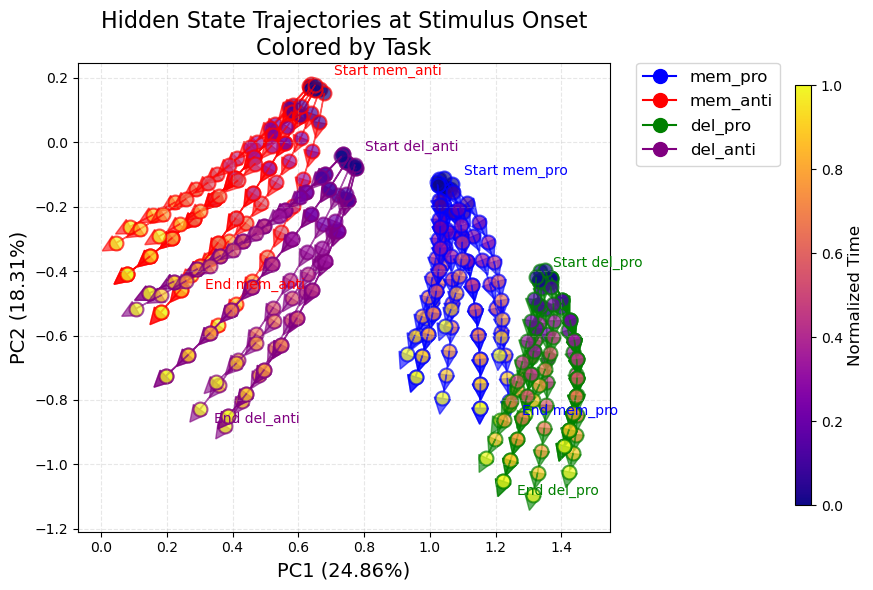

In [248]:
plot_task_arrangement_at(hiddens_by_task,stimulus_onset,10)

In [250]:
# Calculate color values first
stim_colors_by_task = calculate_color_angles(inputs_by_task)
response_colors_by_task = calculate_color_angles(targets_by_task)

# Then plot with your desired coloring mode
plot_task_arrangement_at(hiddens_by_task, stimulus_onset, 10, 
                        color_mode='stim', 
                        stim_colors_by_task=stim_colors_by_task)

(20, 120, 7)
(20, 120, 7)
(20, 120, 7)
(20, 120, 7)
(20, 120, 3)
(20, 120, 3)
(20, 120, 3)
(20, 120, 3)


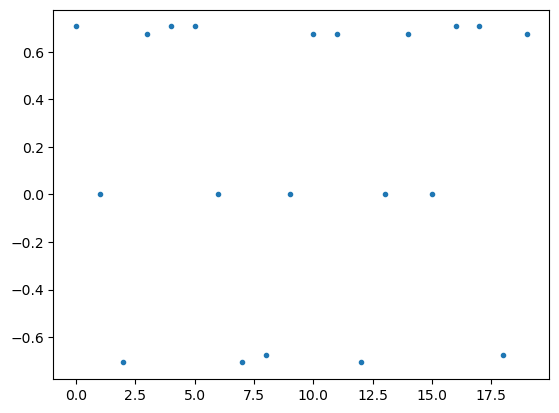

In [263]:
plt.plot(stim_colors_by_task['mem_pro'],'.')

/var/folders/rv/bpj1qnwx5lz32q8rr9jxs07h0000gp/T/ipykernel_17296/3603958739.py:265: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


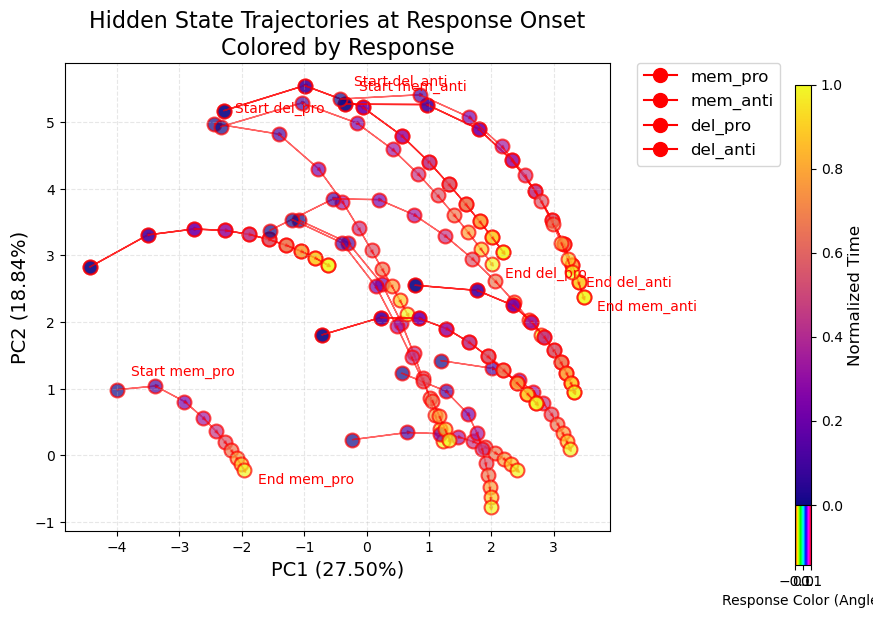

In [226]:
plot_task_arrangement_at(hiddens_by_task,response_onset,10,
                         color_mode='response',
                         response_colors_by_task=response_colors_by_task)

In [230]:
def calculate_color_angles(data_by_task, timestep=40, feature1=1, feature2=2, use_raw=True):
    """
    Calculate angular values from the input or target data for coloring.
    
    Parameters:
    -----------
    data_by_task : dict
        Dictionary mapping task names to data tensors
    timestep : int
        Timestep to extract features from
    feature1 : int
        Feature index for x-component
    feature2 : int
        Feature index for y-component
    use_raw : bool
        If True, use raw feature values for arctan2 (recommended)
        If False, use sine/cosine transformed values
        
    Returns:
    --------
    dict : Dictionary mapping task names to arrays of angular values
    """
    colors_by_task = {}
    for task_name, data in data_by_task.items():
        # Convert to numpy for calculation
        data_np = tensor_to_numpy(data)
        
        if use_raw:
            # Use raw feature values directly (better distribution)
            x = data_np[:, timestep, feature1]
            y = data_np[:, timestep, feature2]
        else:
            # Use transformed values (original approach, may lead to limited color range)
            y = np.sin(data_np[:, timestep, feature2])
            x = np.cos(data_np[:, timestep, feature1])
            
        colors_by_task[task_name] = np.arctan2(y, x)
    
    return colors_by_task


def setup_colormaps(color_mode, hiddens_by_task, stim_colors_by_task, response_colors_by_task):
    """
    Set up colormaps for different coloring modes.
    
    Parameters:
    -----------
    color_mode : str
        One of 'task', 'stim', or 'response'
    hiddens_by_task : dict
        Dictionary of hidden states by task
    stim_colors_by_task : dict
        Dictionary of stimulus colors by task
    response_colors_by_task : dict
        Dictionary of response colors by task
    
    Returns:
    --------
    tuple : (colormap, normalization, color title)
    """
    if color_mode not in ['stim', 'response']:
        return None, None, "Task"
    
    # Create a colormap for angular values
    angle_cmap = plt.cm.hsv
    
    # Get the appropriate color dictionary
    color_dict = None
    if color_mode == 'stim' and stim_colors_by_task is not None:
        color_dict = stim_colors_by_task
        color_title = "Stimulus"
    elif color_mode == 'response' and response_colors_by_task is not None:
        color_dict = response_colors_by_task
        color_title = "Response"
    else:
        return None, None, "Task"
    
    # Always use circular normalization for angles
    # This ensures we use the full color spectrum for angular data
    min_color, max_color = -np.pi, np.pi
    
    # Create normalization function
    # For angular data, use a circular normalization
    # This maps the full -π to π range to the hsv colormap
    norm = plt.Normalize(min_color, max_color)
    
    return angle_cmap, norm, color_title


def main_analysis(inputs_by_task, targets_by_task, hiddens_by_task, onset_period, rel, pca):
    """
    Run the main analysis and plotting workflow.
    
    Parameters:
    -----------
    inputs_by_task : dict
        Dictionary mapping task names to input data
    targets_by_task : dict
        Dictionary mapping task names to target data
    hiddens_by_task : dict
        Dictionary mapping task names to hidden states
    onset_period : dict
        Dictionary mapping task names to onset periods
    rel : int
        Relative period to plot
    pca : sklearn.decomposition.PCA
        Fitted PCA model for dimensionality reduction
    """
    # Calculate color angles
    print("Calculating stimulus colors (raw feature method)...")
    stim_colors_by_task = calculate_color_angles(
        inputs_by_task, 
        use_raw=True  # Use raw features for better color distribution
    )
    
    print("Calculating response colors (raw feature method)...")
    response_colors_by_task = calculate_color_angles(
        targets_by_task, 
        use_raw=True  # Use raw features for better color distribution
    )
    
    # 1. Task colors (default)
    print("Plotting with task colors...")
    plot_task_arrangement_at(
        hiddens_by_task, onset_period, rel, 
        color_mode='task', pca=pca
    )
    
    # 2. Stimulus colors
    print("Plotting with stimulus colors...")
    plot_task_arrangement_at(
        hiddens_by_task, onset_period, rel,
        color_mode='stim',
        stim_colors_by_task=stim_colors_by_task,
        pca=pca
    )
    
    # 3. Response colors
    print("Plotting with response colors...")
    plot_task_arrangement_at(
        hiddens_by_task, onset_period, rel,
        color_mode='response',
        response_colors_by_task=response_colors_by_task,
        pca=pca
    )

In [232]:
main_analysis(inputs_by_task, targets_by_task, hiddens_by_task, stimulus_onset, 10, pca)

Calculating stimulus colors (raw feature method)...


NameError: name 'tensor_to_numpy' is not defined

In [152]:
def compute_representation_metric(rep1, rep2, metric='cosine'):
    """
    Compute representation similarity or distance between two representations.
    
    Parameters:
    -----------
    rep1 : torch.Tensor
        First set of representations
    rep2 : torch.Tensor
        Second set of representations
    metric : str, optional (default='cosine')
        Type of metric to compute. Options:
        - 'cosine': Cosine similarity
        - 'euclidean': Euclidean distance
    
    Returns:
    --------
    float
        Computed similarity or distance metric
    """
    # Flatten representations
    rep1_flat = rep1.reshape(rep1.shape[0], -1)
    rep2_flat = rep2.reshape(rep2.shape[0], -1)
    
    if metric == 'cosine':
        # Normalize
        rep1_norm = rep1_flat / torch.norm(rep1_flat, dim=1, keepdim=True)
        rep2_norm = rep2_flat / torch.norm(rep2_flat, dim=1, keepdim=True)
        
        # Compute mean similarity
        similarity = torch.mean(torch.mm(rep1_norm, rep2_norm.t()))
        return similarity.item()
    
    elif metric == 'euclidean':
        # Compute pairwise Euclidean distances
        distances = torch.norm(rep1_flat-rep2_flat)
        
        # Compute mean distance
        distance = torch.mean(distances)
        return distance.item()
    
    else:
        raise ValueError(f"Unsupported metric: {metric}. Choose 'cosine' or 'euclidean'.")

def analyze_representations_over_time(hiddens_by_task, task_segments, metric='cosine'):
    """
    Analyze representation metrics between different task types over time.
    
    Parameters:
    -----------
    hiddens_by_task : dict
        Dictionary of hidden states for different tasks
    task_segments : dict
        Dictionary defining task segment boundaries
    metric : str, optional (default='cosine')
        Type of metric to compute. Options:
        - 'cosine': Cosine similarity
        - 'euclidean': Euclidean distance
    
    Returns:
    --------
    dict
        Dictionary of computed metrics between task type pairs
    """
    # Determine time points
    time_points = range(list(hiddens_by_task.values())[0].shape[1])
    
    # Initialize metrics dictionary
    metrics = {
        'mem_pro-mem_anti': [],
        'mem_pro-del_pro': [],
        'mem_anti-del_anti': [],
        'del_pro-del_anti': []
    }
    
    for t in time_points:
        # Get hidden states at this time point
        time_hiddens = {task: hidden[:, t] for task, hidden in hiddens_by_task.items() 
                       if task in hiddens_by_task and hidden.shape[0] > 0}
        
        # Compute metrics between task types
        task_pairs = [
            ('mem_pro', 'mem_anti'),
            ('mem_pro', 'del_pro'),
            ('mem_anti', 'del_anti'),
            ('del_pro', 'del_anti')
        ]
        
        for task1, task2 in task_pairs:
            if task1 in time_hiddens and task2 in time_hiddens:
                pair_key = f'{task1}-{task2}'
                metrics[pair_key].append(
                    compute_representation_metric(
                        time_hiddens[task1], 
                        time_hiddens[task2], 
                        metric=metric
                    )
                )
    
    # Plotting
    plt.figure(figsize=(12, 6))
    for pair, metric_values in metrics.items():
        if metric_values:  # Only plot if we have values
            plt.plot(time_points[:len(metric_values)], metric_values, label=pair)
    
    # Mark task segment boundaries
    for task_name, segments in task_segments.items():
        for i, (start, end) in enumerate(segments):
            if i == 0:  # Only add one vertical line per boundary
                plt.axvline(x=start, color='gray', linestyle='--', alpha=0.5)
            plt.axvline(x=end, color='gray', linestyle='--', alpha=0.5)
    
    # Set title and labels based on metric
    metric_label = 'Cosine Similarity' if metric == 'cosine' else 'Euclidean Distance'
    plt.title(f"Representation {metric_label} Between Tasks Over Time")
    plt.xlabel("Time")
    plt.ylabel(metric_label)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    return metrics

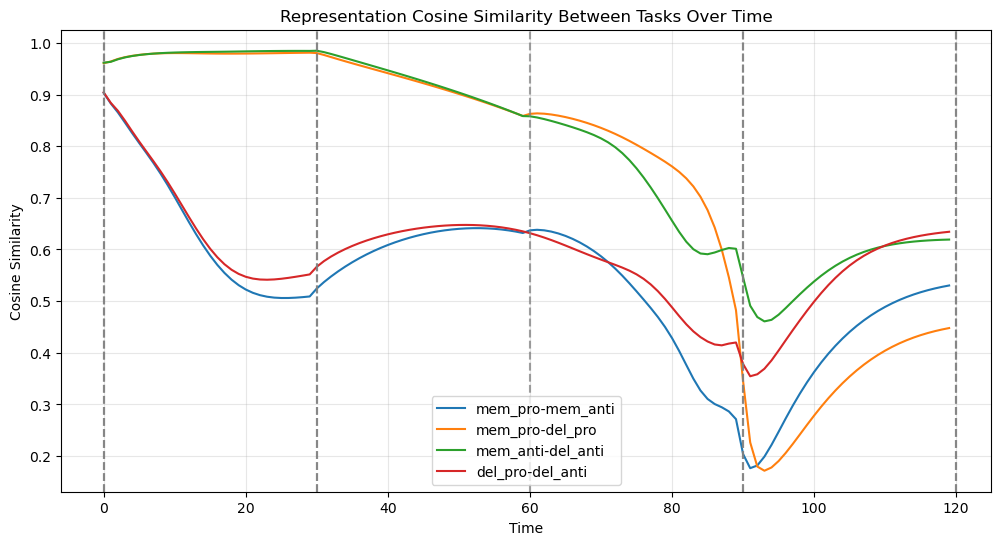

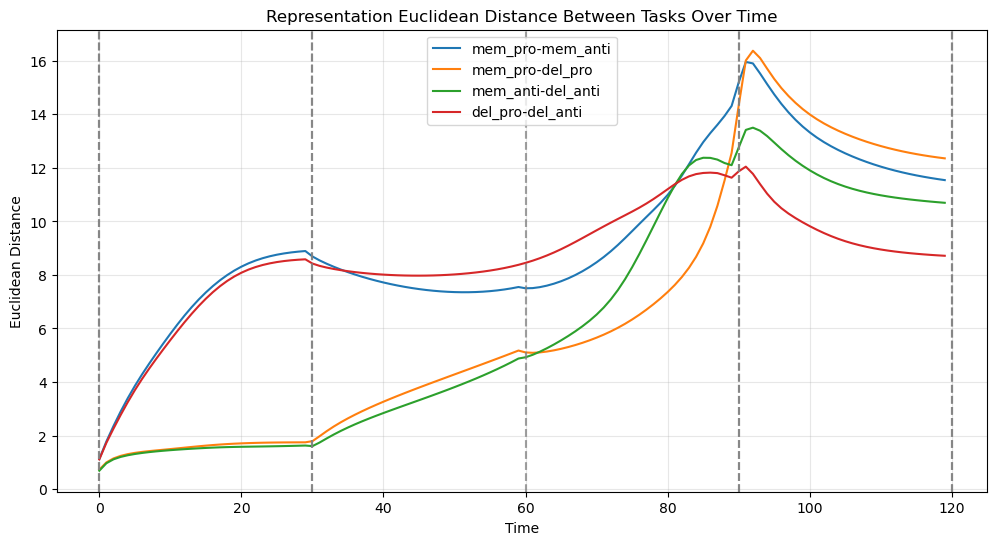

In [153]:
# Example usage:
metrics_cosine = analyze_representations_over_time(hiddens_by_task, task_segments, metric='cosine')
metrics_euclidean = analyze_representations_over_time(hiddens_by_task, task_segments, metric='euclidean')

Analyzing adjoints for mem_pro...
Analyzing adjoints for mem_anti...
Analyzing adjoints for del_pro...
Analyzing adjoints for del_anti...
Explained variance by top adjoint components:
Component 1: 72.11%
Component 2: 27.85%
Component 3: 0.04%
Component 4: 0.00%
Component 5: 0.00%
Component 6: 0.00%
Component 7: 0.00%
Component 8: 0.00%
Component 9: 0.00%
Component 10: 0.00%


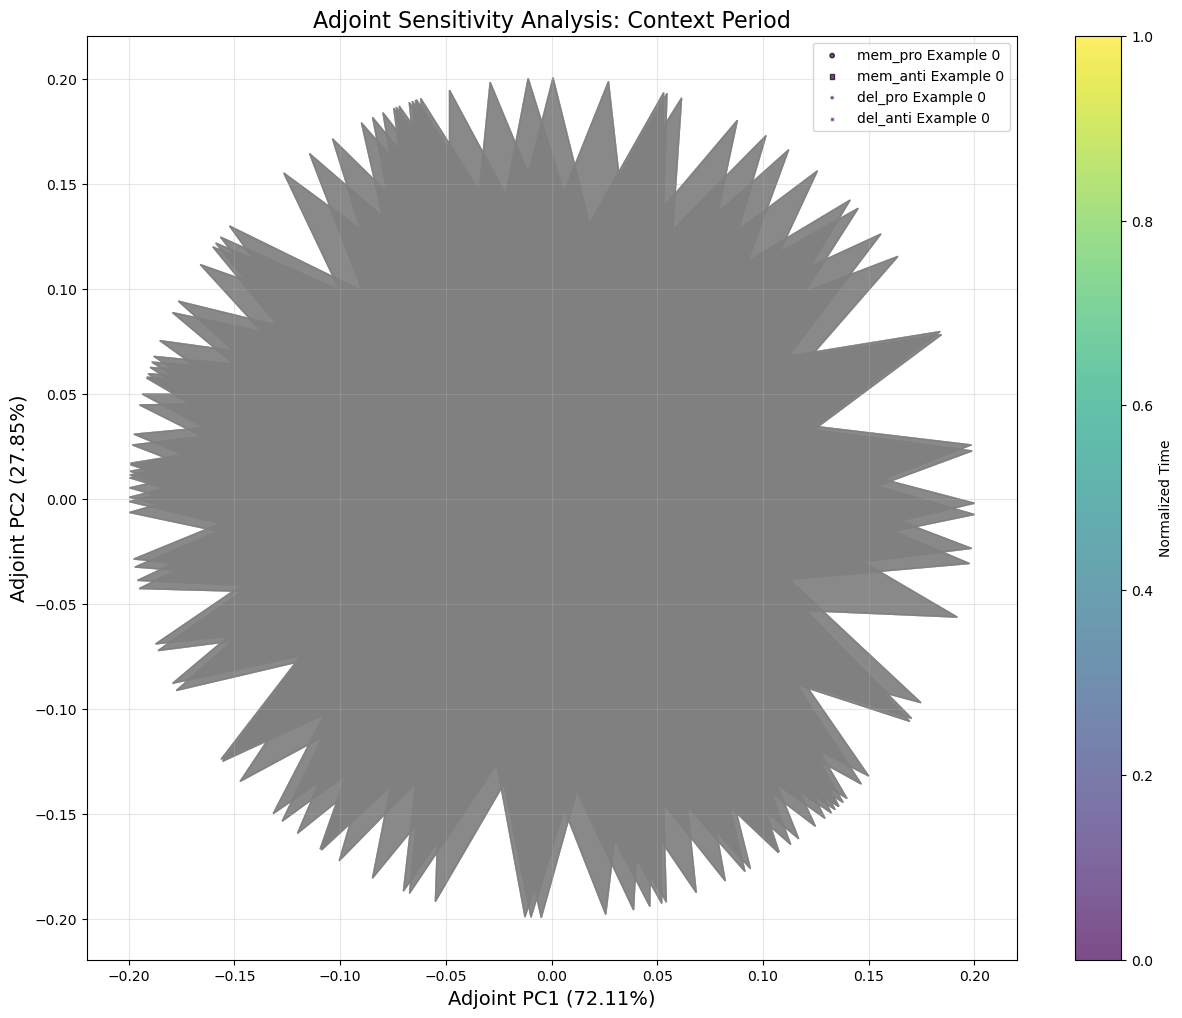

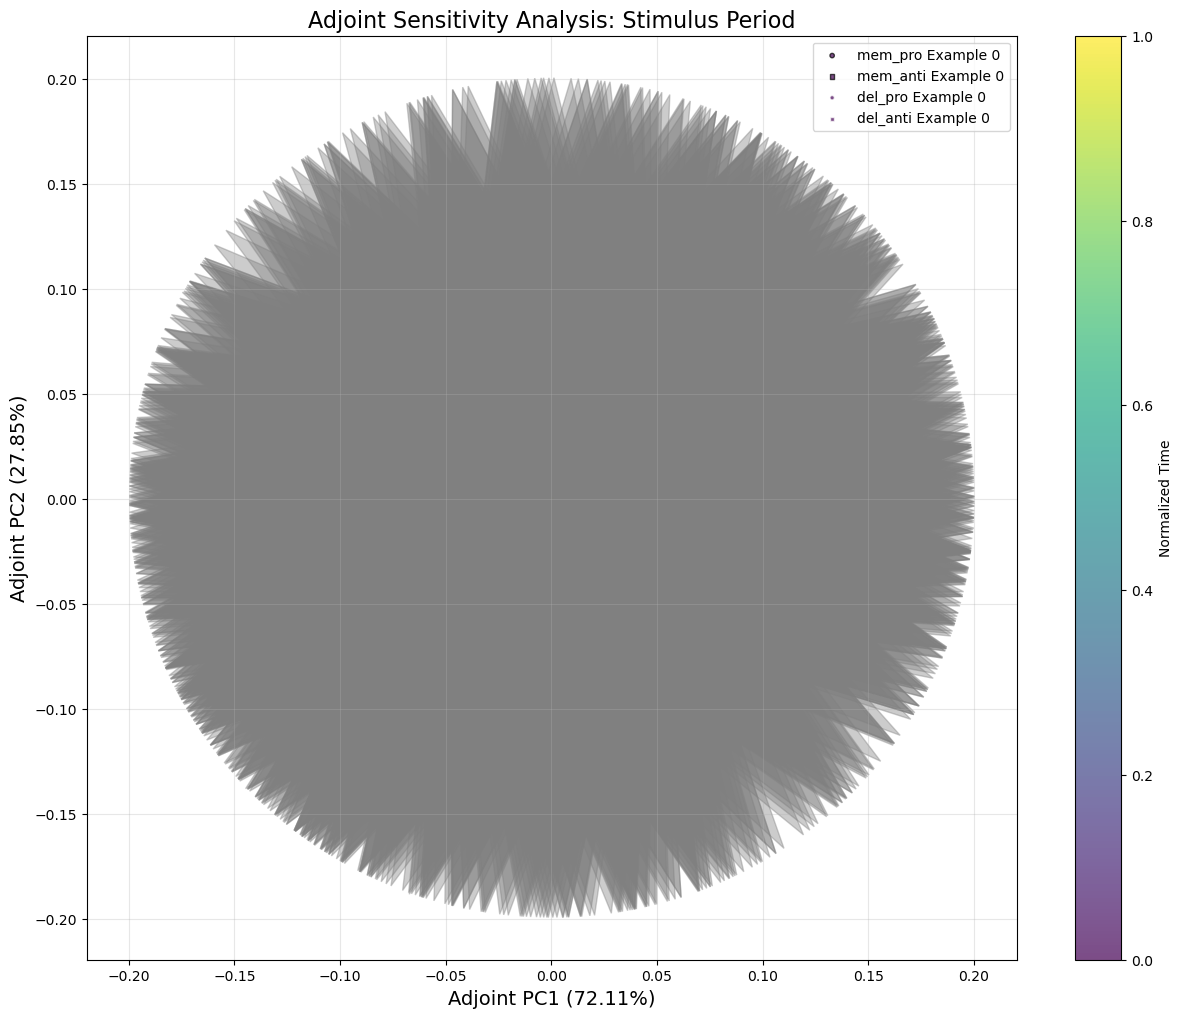

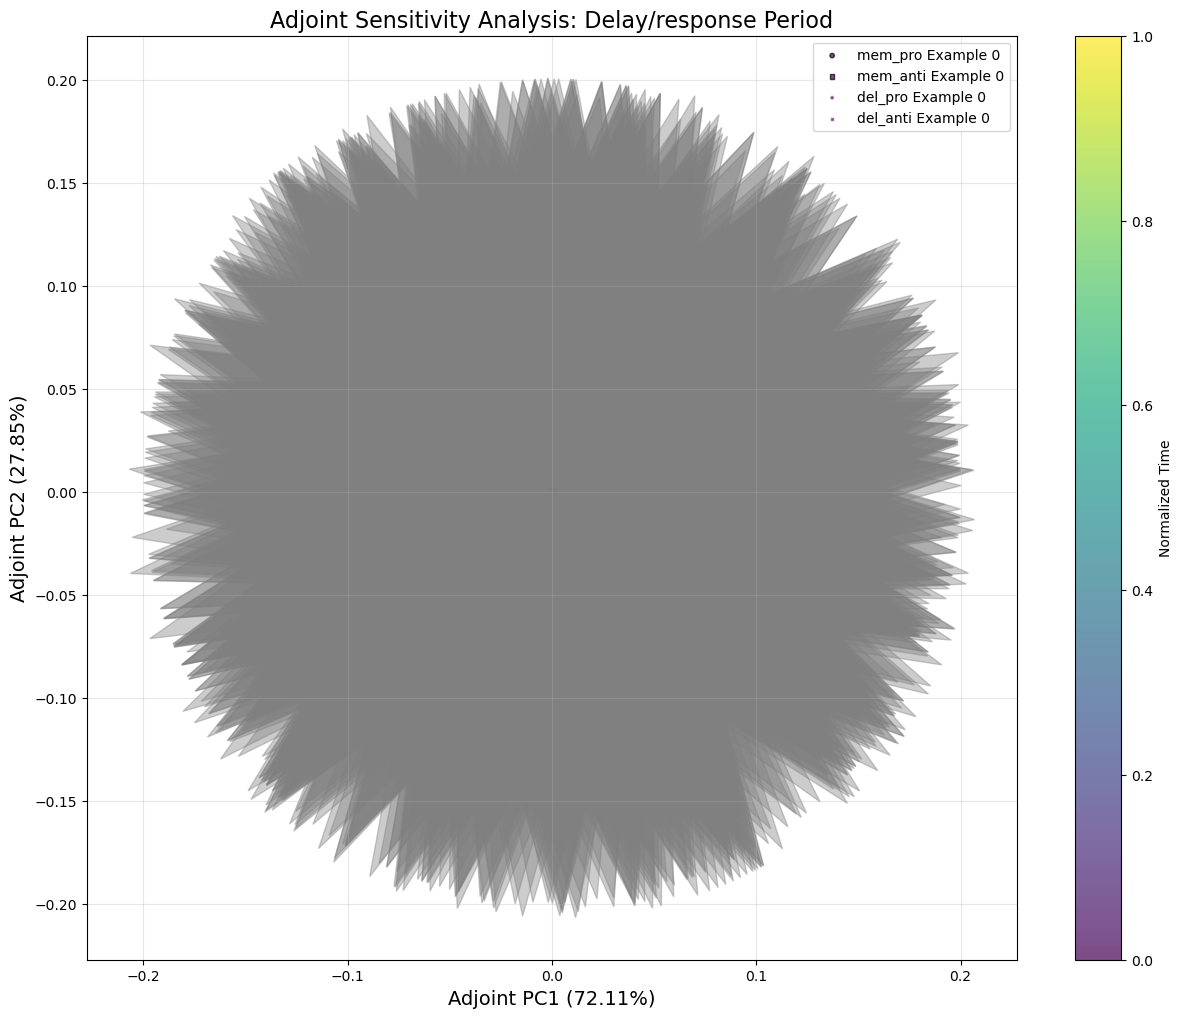

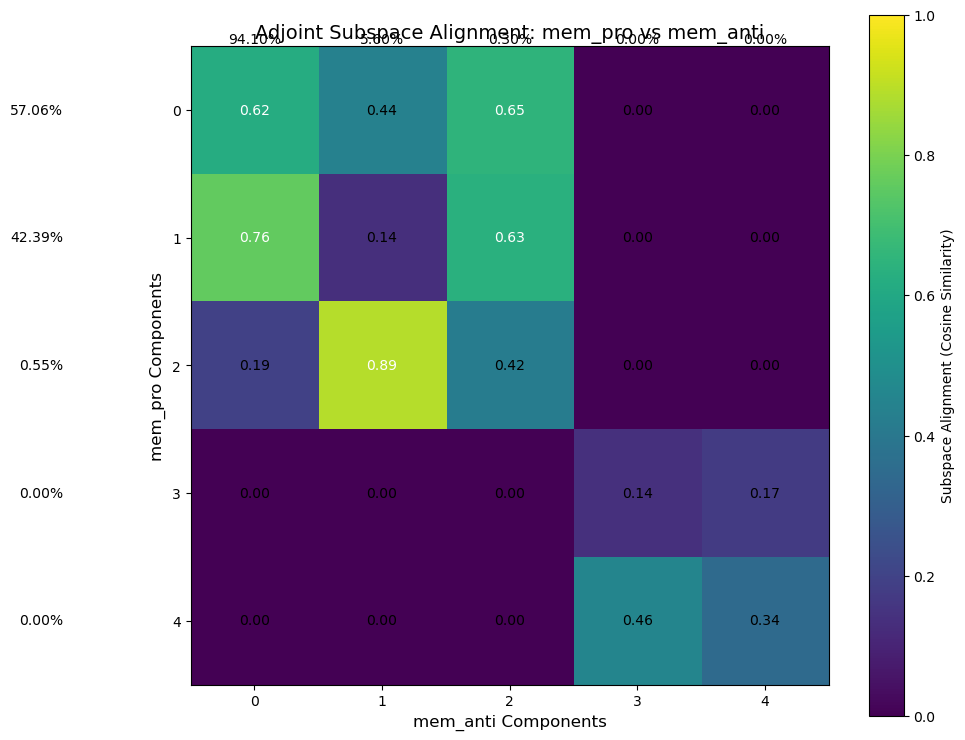

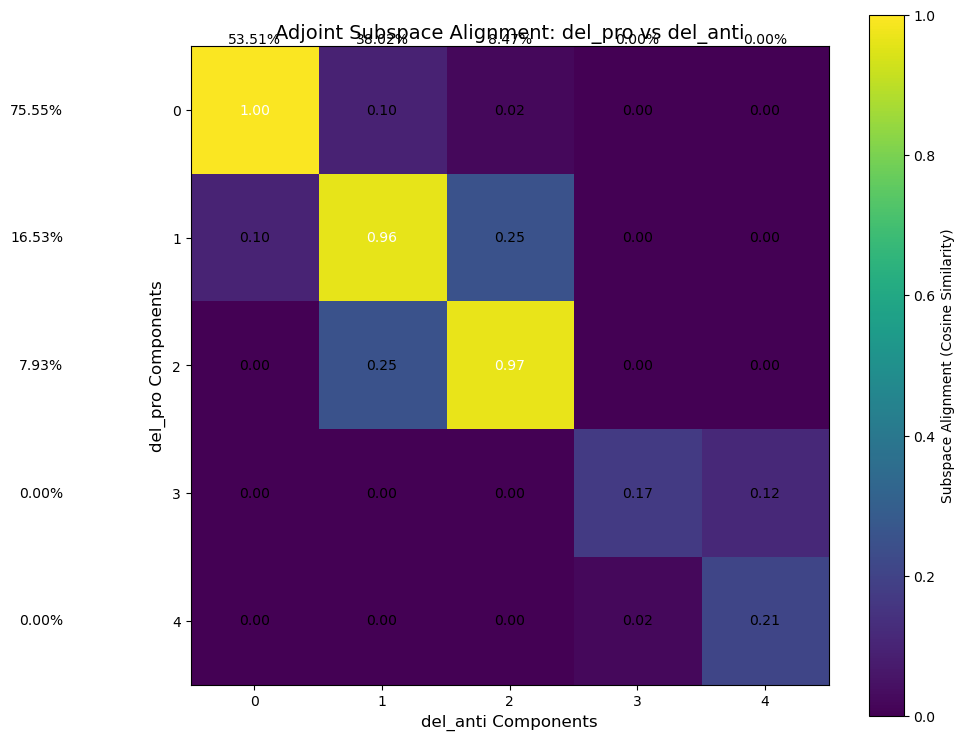

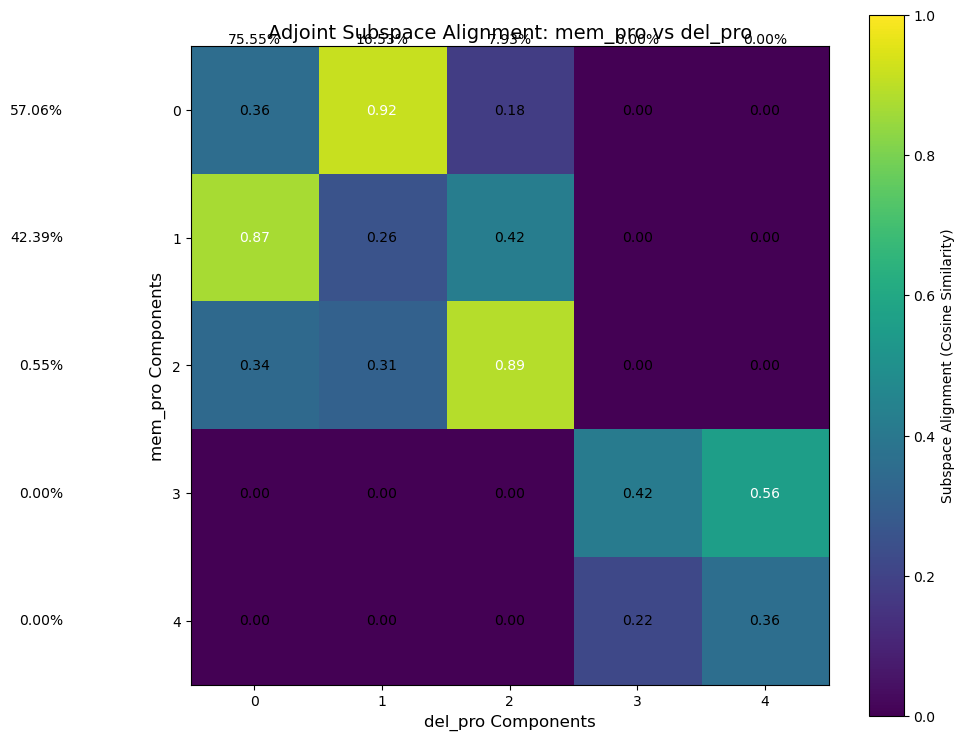

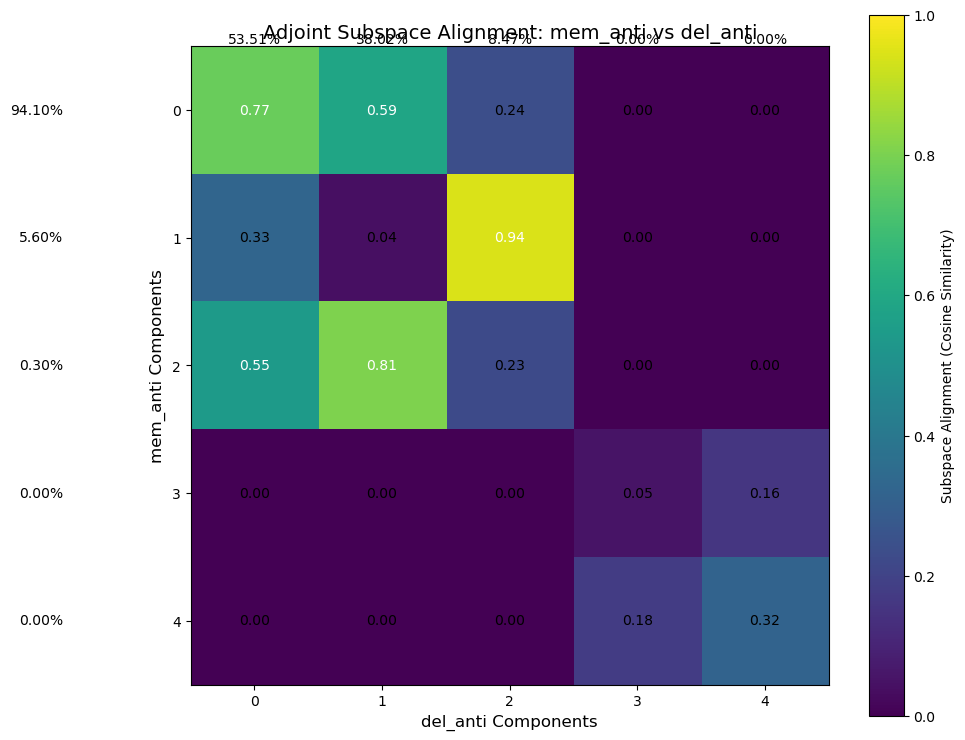

In [156]:
# Compute adjoints for each task type with proper indexing
task_results = {}

for task_name, task_inputs in input_split.items():
    print(f"Analyzing adjoints for {task_name}...")
    
    # Select a subset of examples for clearer visualization
    n_examples = min(5, task_inputs.shape[0])
    
    if n_examples > 0:
        # Get inputs and targets for this task
        task_inputs_subset = task_inputs[:n_examples].to(device)
        
        # Make sure we're using the correct indices for targets
        # Instead of reusing the splits, let's create matching target inputs
        matching_targets = targets[:task_inputs.shape[0]]  # Use same number of targets as inputs
        task_targets_subset = matching_targets[:n_examples].to(device)
        
        # Get segments for this task
        segments = task_segments[task_name]
        
        # Compute hidden states and adjoints for each example
        example_results = []
        for i in range(n_examples):
            hidden, adjoint, out, loss_unreduced, loss = model.analysis_mode(
                task_inputs_subset[i:i+1], 
                task_targets_subset[i:i+1]
            )
            
            # Store results
            example_results.append({
                'hidden': hidden.detach().cpu(),
                'adjoint': adjoint.detach().cpu(),
                'out': out.detach().cpu(),
                'loss': loss_unreduced.detach().cpu(),
                'segments': segments
            })
        
        task_results[task_name] = example_results

# Combine all adjoints for dimensionality reduction
all_adjoints = []
for task_results_list in task_results.values():
    for result in task_results_list:
        all_adjoints.append(result['adjoint'].reshape(-1, result['adjoint'].shape[-1]))

all_adjoints_tensor = torch.cat(all_adjoints, dim=0)
all_adjoints_np = all_adjoints_tensor.numpy()

# Apply PCA to find the most important dimensions
pca = PCA(n_components=10)  # Get top 10 components
pca.fit(all_adjoints_np)

# Print explained variance for top components
print("Explained variance by top adjoint components:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"Component {i+1}: {ratio:.2%}")

# Analyze adjoint activations during different task segments
for segment_idx in range(min(len(task_segments[next(iter(task_segments))]), 3)):
    segment_name = ['context', 'stimulus', 'delay/response'][segment_idx]
    
    plt.figure(figsize=(15, 12))
    
    for task_name, task_results_list in task_results.items():
        # Extract segment boundaries
        if segment_idx < len(task_segments[task_name]):
            start, end = task_segments[task_name][segment_idx]
            
            for ex_idx, result in enumerate(task_results_list):
                # Get adjoints for this segment
                segment_adjoints = result['adjoint'][0, start:end]
                
                # Project to top 2 PCA components
                segment_pca = pca.transform(segment_adjoints.numpy())
                
                # Plot with time-based color gradient
                time_points = np.linspace(0, 1, len(segment_pca))
                
                # Setup plot
                plt.scatter(segment_pca[:, 0], segment_pca[:, 1], 
                          c=time_points, cmap='viridis', 
                          marker='o' if 'pro' in task_name else 's',  # Different markers for pro/anti
                          edgecolors='k' if 'mem' in task_name else 'w',  # Different edges for memory/delay
                          s=10, alpha=0.7,
                          label=f"{task_name} Example {ex_idx}" if ex_idx == 0 else "")
                
                # Add arrows to show direction
                for t in range(len(segment_pca)-1):
                    plt.arrow(segment_pca[t, 0], segment_pca[t, 1],
                            segment_pca[t+1, 0] - segment_pca[t, 0],
                            segment_pca[t+1, 1] - segment_pca[t, 1],
                            head_width=0.1, head_length=0.2, 
                            fc='gray', ec='gray', alpha=0.4)
    
    plt.title(f"Adjoint Sensitivity Analysis: {segment_name.capitalize()} Period", fontsize=16)
    plt.xlabel(f"Adjoint PC1 ({pca.explained_variance_ratio_[0]:.2%})", fontsize=14)
    plt.ylabel(f"Adjoint PC2 ({pca.explained_variance_ratio_[1]:.2%})", fontsize=14)
    plt.colorbar(label="Normalized Time")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Compute subspace alignment between task types
def compute_subspace_alignment(adjoints1, adjoints2, n_components=5):
    """Compute alignment between top PCA components of two adjoint sets"""
    # Flatten adjoints
    adj1_flat = adjoints1.reshape(-1, adjoints1.shape[-1]).numpy()
    adj2_flat = adjoints2.reshape(-1, adjoints2.shape[-1]).numpy()
    
    # Compute principal components
    pca1 = PCA(n_components=n_components)
    pca2 = PCA(n_components=n_components)
    
    pca1.fit(adj1_flat)
    pca2.fit(adj2_flat)
    
    # Get the top components
    comp1 = pca1.components_  # Shape: (n_components, n_features)
    comp2 = pca2.components_
    
    # Compute alignment (cosine similarity) between all pairs
    alignment = np.zeros((n_components, n_components))
    for i in range(n_components):
        for j in range(n_components):
            alignment[i, j] = np.abs(np.dot(comp1[i], comp2[j])) / (np.linalg.norm(comp1[i]) * np.linalg.norm(comp2[j]))
    
    return alignment, pca1.explained_variance_ratio_, pca2.explained_variance_ratio_

# Compare subspace alignment across task types
task_pairs = [
    ('mem_pro', 'mem_anti'),  # Compare pro vs anti for memory tasks
    ('del_pro', 'del_anti'),  # Compare pro vs anti for delay tasks
    ('mem_pro', 'del_pro'),   # Compare memory vs delay for pro tasks
    ('mem_anti', 'del_anti')  # Compare memory vs delay for anti tasks
]

segment_idx = 1  # Focus on stimulus period (usually most informative)

for task1, task2 in task_pairs:
    if task1 in task_results and task2 in task_results and len(task_results[task1]) > 0 and len(task_results[task2]) > 0:
        # Get adjoints for the segment
        start1, end1 = task_segments[task1][min(segment_idx, len(task_segments[task1])-1)]
        start2, end2 = task_segments[task2][min(segment_idx, len(task_segments[task2])-1)]
        
        adjoints1 = task_results[task1][0]['adjoint'][:, start1:end1]
        adjoints2 = task_results[task2][0]['adjoint'][:, start2:end2]
        
        # Compute alignment
        alignment, var1, var2 = compute_subspace_alignment(adjoints1, adjoints2, n_components=5)
        
        # Plot alignment as a heatmap
        plt.figure(figsize=(10, 8))
        plt.imshow(alignment, cmap='viridis', vmin=0, vmax=1)
        plt.colorbar(label='Subspace Alignment (Cosine Similarity)')
        plt.title(f"Adjoint Subspace Alignment: {task1} vs {task2}", fontsize=14)
        plt.xlabel(f"{task2} Components", fontsize=12)
        plt.ylabel(f"{task1} Components", fontsize=12)
        
        # Add text showing explained variance
        for i in range(5):
            plt.text(-1.5, i, f"{var1[i]:.2%}", va='center', ha='right', fontsize=10)
            plt.text(i, -0.5, f"{var2[i]:.2%}", va='bottom', ha='center', fontsize=10)
        
        # Add text in cells
        for i in range(5):
            for j in range(5):
                plt.text(j, i, f"{alignment[i, j]:.2f}", va='center', ha='center',
                       color='white' if alignment[i, j] > 0.5 else 'black', fontsize=10)
        
        plt.tight_layout()
        plt.show()

In [142]:
def compute_adjoint_sensitivity(model, inputs, targets, device):
    """
    Compute the adjoint sensitivity (gradient of loss w.r.t. hidden states)
    """
    model.eval()
    batch_size = inputs.shape[0]
    seq_len = inputs.shape[1]
    hidden_size = model.rnn.hidden_size
    
    # Forward pass with gradient tracking for hidden states
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    # Run model with hooks to capture hidden states
    hidden_states = []
    
    def hook_fn(module, input, output):
        # Output is (hidden_states, cell_states)
        hidden_states.append(output[0].detach().requires_grad_(True))
    
    hook = model.rnn.register_forward_hook(hook_fn)
    
    # Forward pass
    outputs, _ = model(inputs)
    loss = loss_fn(outputs, targets)
    
    # Remove the hook
    hook.remove()
    
    # Compute gradients w.r.t hidden states
    adjoints = []
    for h in hidden_states:
        # Create a fresh graph for each hidden state
        h_copy = h.detach().requires_grad_(True)
        outputs = model.Wout(h_copy)
        loss = loss_fn(outputs, targets)
        loss.backward()
        adjoints.append(h_copy.grad.detach().cpu())
    
    return torch.stack(adjoints, dim=1), torch.stack(hidden_states, dim=1).detach().cpu()

In [143]:
def analyze_task_representations(model, task_dataloader, device, n_samples=100):
    """
    Analyze task representations in state space using adjoints
    """
    # Collect data for each task type
    task_adjoints = {
        'mem_pro': [], 'mem_anti': [], 
        'delay_pro': [], 'delay_anti': []
    }
    task_hiddens = {
        'mem_pro': [], 'mem_anti': [], 
        'delay_pro': [], 'delay_anti': []
    }
    
    # Get sample data for each task
    for i, (inputs, targets) in enumerate(task_dataloader):
        if i >= n_samples:
            break
            
        # Determine task type from one-hot encoding
        # The task type is encoded in the 4 channels (indices 3-6)
        # during the context period
        task_idx = torch.argmax(inputs[0, 0, 3:7]).item()
        task_name = ['mem_pro', 'mem_anti', 'delay_pro', 'delay_anti'][task_idx]
        
        # Compute adjoints
        adjoint, hidden = compute_adjoint_sensitivity(model, inputs, targets, device)
        
        # Store by task type
        task_adjoints[task_name].append(adjoint)
        task_hiddens[task_name].append(hidden)
    
    # Convert to tensors
    for task in task_adjoints:
        task_adjoints[task] = torch.cat(task_adjoints[task], dim=0)
        task_hiddens[task] = torch.cat(task_hiddens[task], dim=0)
    
    return task_adjoints, task_hiddens

In [144]:
def visualize_task_organization(task_adjoints, task_hiddens, timepoint=50):
    """
    Visualize task organization in state space using PCA
    """
    # Extract adjoints at specific timepoint
    adjoints = {
        task: data[:, timepoint, :] for task, data in task_adjoints.items()
    }
    
    # Concatenate all adjoints for PCA
    all_adjoints = torch.cat(list(adjoints.values()), dim=0).numpy()
    
    # Apply PCA
    pca = PCA(n_components=2)
    all_adjoints_pca = pca.fit_transform(all_adjoints)
    
    # Split back by task
    task_sizes = {task: data.shape[0] for task, data in adjoints.items()}
    start_idx = 0
    adjoints_pca = {}
    
    for task, size in task_sizes.items():
        adjoints_pca[task] = all_adjoints_pca[start_idx:start_idx + size]
        start_idx += size
    
    # Plot
    plt.figure(figsize=(10, 8))
    colors = {'mem_pro': 'blue', 'mem_anti': 'red', 'delay_pro': 'green', 'delay_anti': 'purple'}
    markers = {'mem_pro': 'o', 'mem_anti': 's', 'delay_pro': '^', 'delay_anti': 'D'}
    
    for task, data in adjoints_pca.items():
        plt.scatter(data[:, 0], data[:, 1], c=colors[task], marker=markers[task], 
                   label=task, alpha=0.7, s=50)
    
    plt.title(f'Task Organization in Adjoint Space at t={timepoint}')
    plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Calculate cluster centers
    centers = {task: np.mean(data, axis=0) for task, data in adjoints_pca.items()}
    
    # Plot cluster centers
    for task, center in centers.items():
        plt.scatter(center[0], center[1], c='black', s=100, alpha=1.0)
        plt.text(center[0], center[1], task, fontsize=12, ha='center')
    
    # Add annotation lines showing compositional structure
    # Line between mem_pro and mem_anti (pro/anti axis for memory tasks)
    plt.plot([centers['mem_pro'][0], centers['mem_anti'][0]], 
             [centers['mem_pro'][1], centers['mem_anti'][1]], 'k--', alpha=0.5)
    
    # Line between delay_pro and delay_anti (pro/anti axis for delay tasks)
    plt.plot([centers['delay_pro'][0], centers['delay_anti'][0]], 
             [centers['delay_pro'][1], centers['delay_anti'][1]], 'k--', alpha=0.5)
    
    # Line between mem_pro and delay_pro (memory/delay axis for pro tasks)
    plt.plot([centers['mem_pro'][0], centers['delay_pro'][0]], 
             [centers['mem_pro'][1], centers['delay_pro'][1]], 'k-.', alpha=0.5)
    
    # Line between mem_anti and delay_anti (memory/delay axis for anti tasks)
    plt.plot([centers['mem_anti'][0], centers['delay_anti'][0]], 
             [centers['mem_anti'][1], centers['delay_anti'][1]], 'k-.', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Return variance explained to assess dimensionality
    return pca.explained_variance_ratio_

In [ ]:
ch_path = 'mix_tasks_gru/'
checkpoints = load_checkpoints(ch_path)[0]
checkpoints_all = list(checkpoints)
print(len(checkpoints))
checkpoints = checkpoints[::5] # Subset
model = Model().to(device)
model.load_state_dict(import_checkpoint(checkpoints[-1]))

task_test  = LauraTaskWrapper('mix_multi_tasks', 1000, use_noise = False, n_samples = 1000, n_spike = 20, T = 90)
inputs, targets = task_test()
out, hidden = model(inputs.to(device))
out, hidden = out.detach().cpu().numpy(), hidden.detach().cpu().numpy()

In [145]:
task_adjoints, task_hiddens = analyze_task_representations(model, dataloader, device)

NameError: name 'dataloader' is not defined

In [146]:
variance_ratios = visualize_task_organization(task_adjoints, task_hiddens, timepoint=50)

NameError: name 'task_adjoints' is not defined

## Evaluate the model over training. See eval at top of this notebook.

In [16]:
pairs = []
grads = []
losses = []
z_next = []
for ch in tqdm(checkpoints_all):
    model, hidden, adjoint, out, W_grad, loss, loss_unreduced = eval(ch)
    grads.append(W_grad)
    losses.append(loss)
    pairs.append([hidden, adjoint])                                                     
    hidden_next = eval_next(model)
    z_next.append(hidden_next)

100%|██████████| 50/50 [00:06<00:00,  8.27it/s]


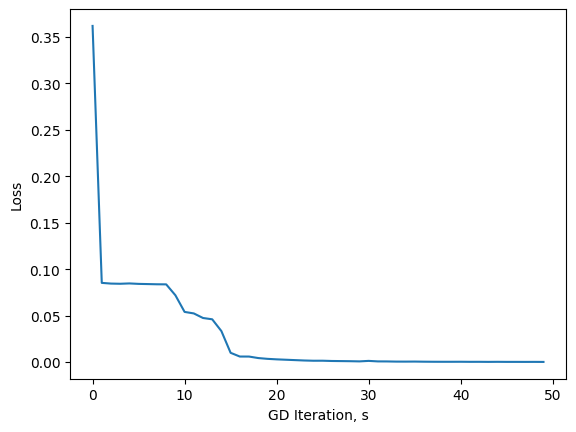

In [17]:
plt.plot(losses)
plt.xlabel('GD Iteration, s')
plt.ylabel('Loss')
plt.show()

50


100%|██████████| 50/50 [00:05<00:00,  8.38it/s]


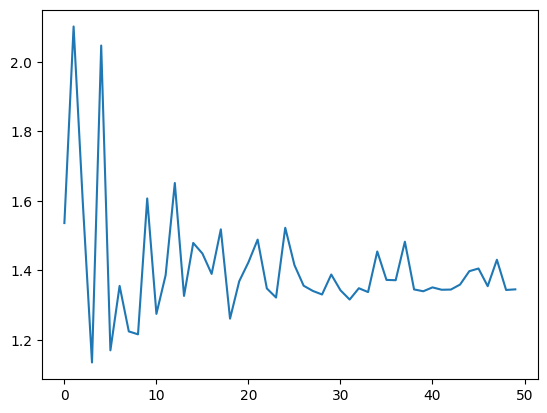

In [41]:

# mu_dz = np.mean(dz, (0, 1))
# mu_z0 = np.mean(z0, (0, 1))
# mu_a0 = np.mean(a0, (0, 1))

print(len(checkpoints_all))
pairs, z_next = [], []
for ch in tqdm(checkpoints_all):
    pairs.append(eval(ch)[1:3])
    hidden_next = eval_next(model)
    z_next.append(hidden_next)
    
plt.plot([angle_between(np.mean(z0, (0, 1)), np.mean(a0, (0, 1))) for (z0, a0) in pairs])

In [42]:
n = pairs[0][0].shape[-1]
get_dir = lambda x, k: get_components(x.reshape(-1, n), k+1, False)[k]
dirs_a0 = [get_components(a0.reshape(-1, n), 10, False) for _, a0 in pairs]
dirs_z0 = [get_components(z0.reshape(-1, n), 10, False) for z0, _ in pairs]
dirs_dz = [get_components((z2 - z1).reshape(-1, n), 10, False) for (z1, _), z2 in zip(pairs, z_next)]

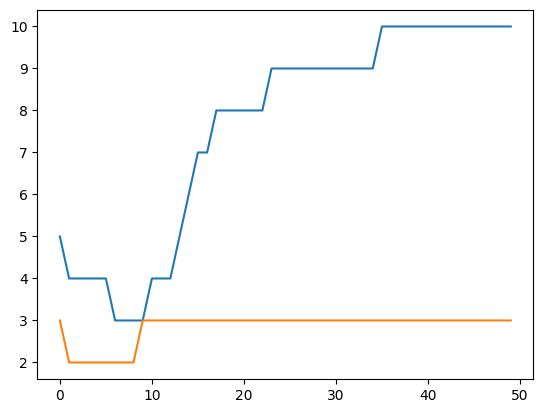

In [43]:
plt.plot([dim for dim, _ in dirs_z0])
plt.plot([dim for dim, _ in dirs_a0])
plt.show()

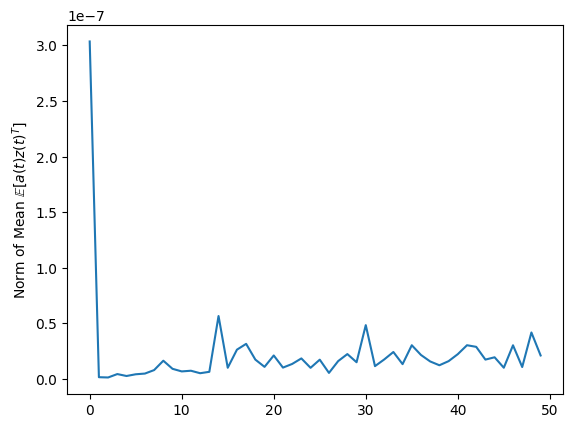

In [44]:
def safe_mean_outer(X, Y, axis):
    n1, n2 = X.shape[axis], Y.shape[axis]
    mat = np.zeros((n1, n2))
    Xax, Yax = np.moveaxis(X, axis, 0), np.moveaxis(Y, axis, 0)
    for i in range(n1):
        mat[i, :] = np.mean(Xax[i:i+1] * Yax)
    return mat

outers = [safe_mean_outer(a0, z0, -1) for z0, a0 in pairs]
outer_norms = [np.linalg.norm(outer) for outer in outers]
plt.plot(outer_norms)
plt.ylabel('Norm of Mean $\\mathbb{E}[a(t) z(t)^T]$')
plt.show()

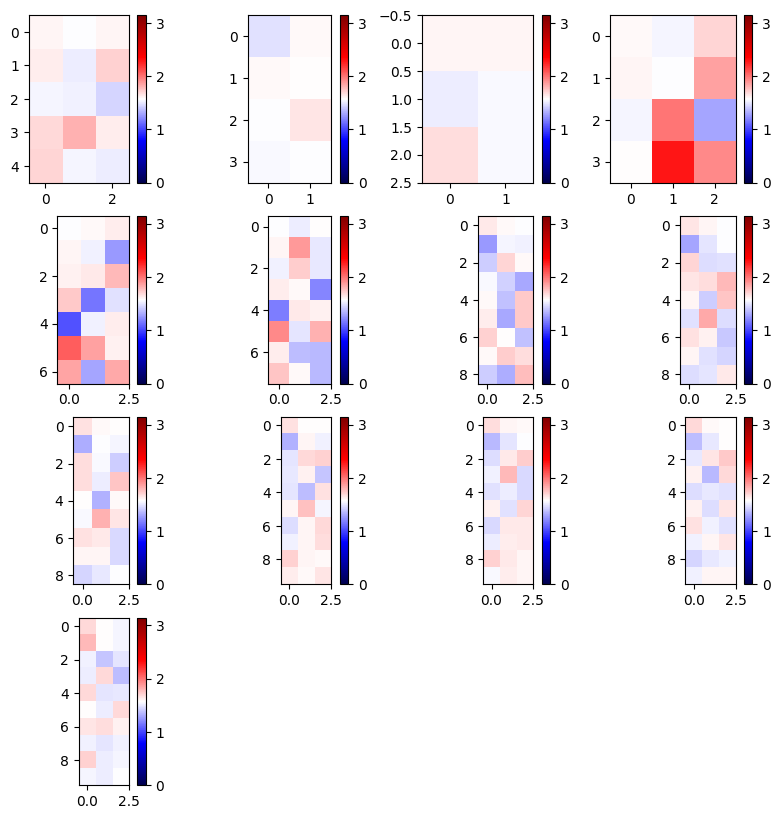

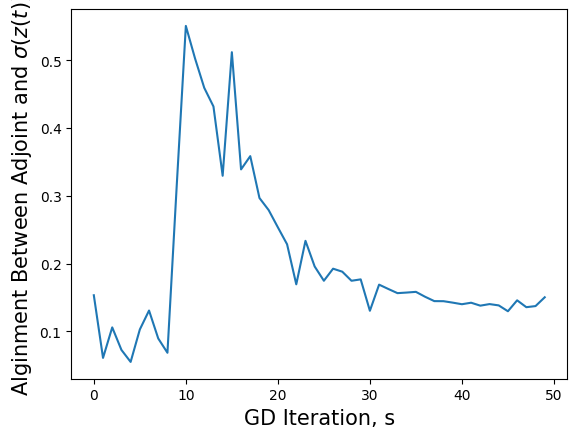

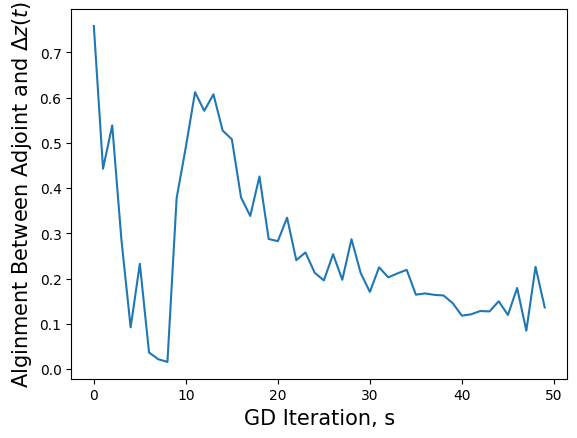

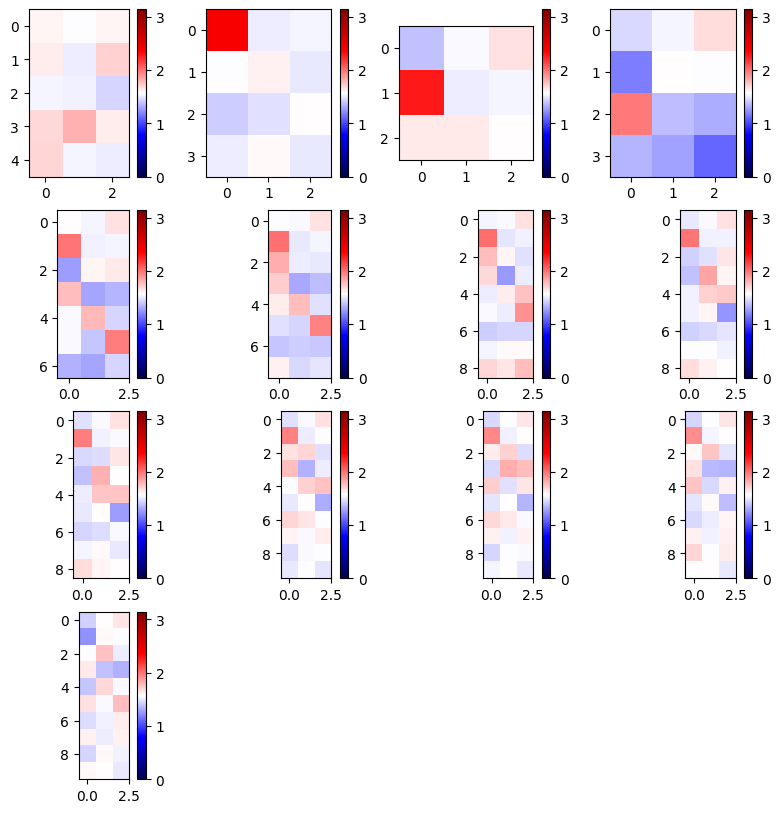

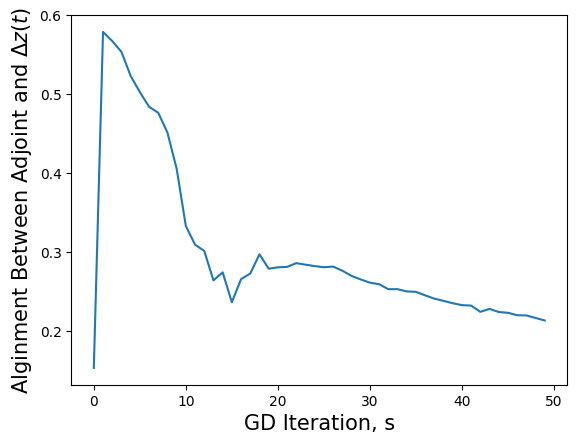

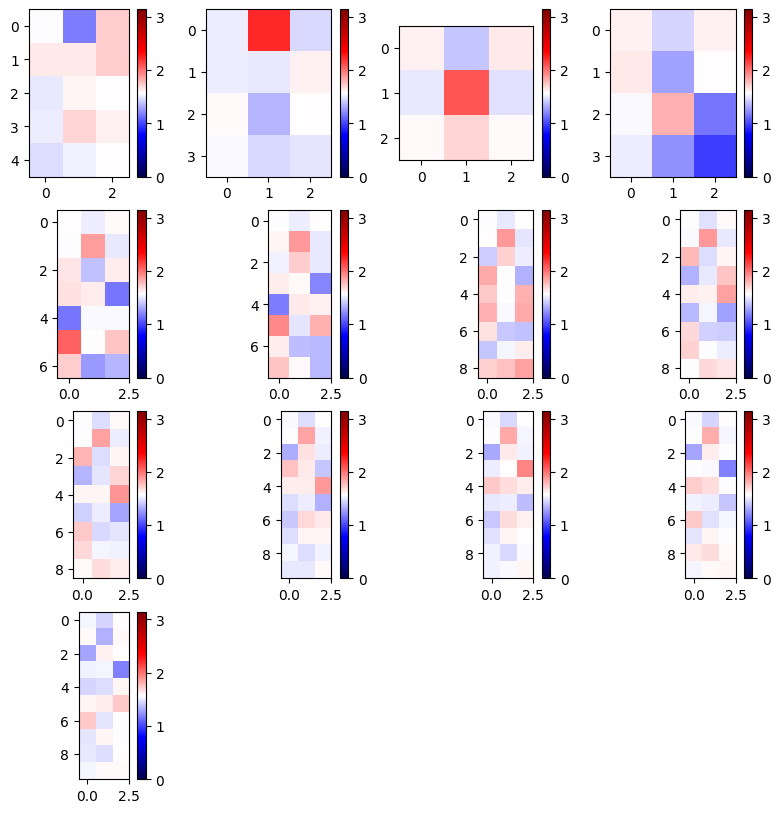

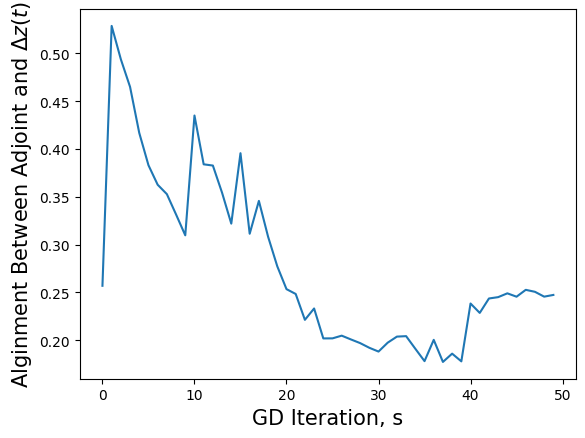

In [45]:
def analyze_relation(X, Y):
    grids = []
    best_diffs = []
    for s in range(len(X)):
        dim1, x = X[s]
        dim2, y = Y[s]
        grid = [[angle_between(dir1, dir2) for dir1 in x[:dim1]] for dir2 in y[:dim2]]
        grids.append(grid)
        best_diff = np.max(np.abs(np.array(grid) - np.pi/2) / (np.pi/2))
        best_diffs.append(best_diff)
    return grids, best_diffs

grids, best_diffs = analyze_relation(dirs_a0, dirs_z0)

plt.figure(figsize = (10, 10))
for idx, grid in enumerate(grids[::4]):
    plt.subplot(4, 4, idx + 1)
    plt.imshow(grid, vmin = 0, vmax = np.pi, cmap = 'seismic')
    plt.colorbar()
plt.show()

plt.plot(best_diffs)
plt.xlabel('GD Iteration, s', fontsize = 15)
plt.ylabel('Alginment Between Adjoint and $\\sigma(z(t))$', fontsize = 15)
plt.show()

grids, best_diffs = analyze_relation(dirs_a0, dirs_dz)

# for idx, grid in enumerate(grids):
#     plt.subplot(3, 4, idx + 1)
#     plt.imshow(grid, vmin = 0, vmax = np.pi, cmap = 'seismic')
# plt.show()

plt.plot(best_diffs)
plt.xlabel('GD Iteration, s', fontsize = 15)
plt.ylabel('Alginment Between Adjoint and $\\Delta z(t)$', fontsize = 15)
plt.show()

init_a0_dir = [dirs_a0[0]] * len(dirs_a0)
init_a0_dir = [(10, d) for _, d in init_a0_dir]
grids, best_diffs = analyze_relation(init_a0_dir, dirs_z0)

plt.figure(figsize = (10, 10))
for idx, grid in enumerate(grids[::4]):
    plt.subplot(4, 4, idx + 1)
    plt.imshow(grid, vmin = 0, vmax = np.pi, cmap = 'seismic')
    plt.colorbar()
plt.show()

plt.plot(best_diffs)
plt.xlabel('GD Iteration, s', fontsize = 15)
plt.ylabel('Alginment Between Adjoint and $\\Delta z(t)$', fontsize = 15)
plt.show()


init_a0_dir = [dirs_a0[20]] * len(dirs_a0)
init_a0_dir = [(10, d) for _, d in init_a0_dir]
grids, best_diffs = analyze_relation(init_a0_dir, dirs_z0)

plt.figure(figsize = (10, 10))
for idx, grid in enumerate(grids[::4]):
    plt.subplot(4, 4, idx + 1)
    plt.imshow(grid, vmin = 0, vmax = np.pi, cmap = 'seismic')
    plt.colorbar()
plt.show()

plt.plot(best_diffs)
plt.xlabel('GD Iteration, s', fontsize = 15)
plt.ylabel('Alginment Between Adjoint and $\\Delta z(t)$', fontsize = 15)
plt.show()

In [146]:
init_dim_adjoint, init_dirs_adjoint = get_components(pairs[0][1].reshape(-1, n), center = False)
proj = np.abs(np.array([[np.inner(dir1, dir2) for dir1 in init_dirs_adjoint] for dir2 in dirs_z0[-1][1]]))
# print(proj.sum(1)[0])
# proj = proj / proj.sum(1, keepdims = True)
plt.figure(figsize = (9, 4))
plt.imshow(proj[:, :20], aspect = 'auto')
plt.colorbar()
plt.xlabel('Initial Adjoint Directions', fontsize = 15)
plt.ylabel('Final State Directions', fontsize = 15)
plt.show()


ValueError: shapes (5,) and (100,) not aligned: 5 (dim 0) != 100 (dim 0)

In [47]:
proj = 0.
for i in tqdm(range(len(pairs))):
    init_dim_adjoint, init_dirs_adjoint = get_components(pairs[i][1].reshape(-1, n), center = False)
    proj = proj + np.abs(np.array([[np.inner(dir1, dir2) for dir1 in init_dirs_adjoint] for dir2 in dirs_z0[-1][1]]))

100%|██████████| 50/50 [01:26<00:00,  1.72s/it]


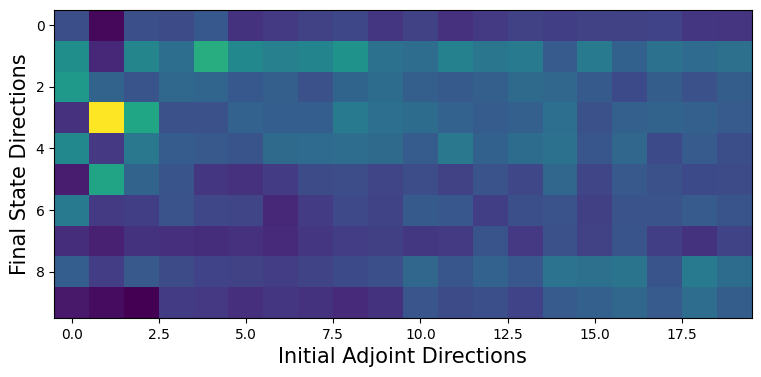

In [50]:
# proj = proj / proj.sum(1, keepdims = True)
plt.figure(figsize = (9, 4))
plt.imshow(proj[:, :20], aspect = 'auto')
# plt.colorbar()
plt.xlabel('Initial Adjoint Directions', fontsize = 15)
plt.ylabel('Final State Directions', fontsize = 15)
plt.show()

In [51]:
proj = 0.
most_aligned = []
mags = []
for i in tqdm(range(len(pairs))):
    init_dim_adjoint, init_dirs_adjoint, vars = get_components(pairs[i][1].reshape(-1, n), center = False, return_var = True)
    proj_i = np.abs(np.array([[np.inner(dir1, dir2) for dir1 in init_dirs_adjoint] for dir2 in dirs_z0[-1][1]]))
    z_ind, a_ind = np.unravel_index(np.argmax(proj_i), proj_i.shape)
    most_aligned.append(z_ind)
    mags.append(vars[a_ind])

 52%|█████▏    | 26/50 [00:43<00:39,  1.65s/it]


KeyboardInterrupt: 

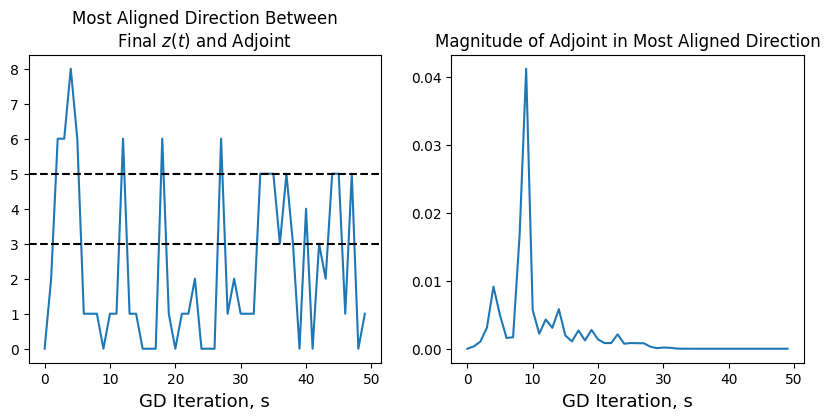

In [ ]:
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.plot(most_aligned)
plt.title('Most Aligned Direction Between\nFinal $z(t)$ and Adjoint')
plt.xlabel('GD Iteration, s', fontsize = 13)
plt.axhline(3, color = 'black', linestyle = 'dashed')
plt.axhline(5, color = 'black', linestyle = 'dashed')

plt.subplot(1,2,2)
plt.plot(mags)
plt.title('Magnitude of Adjoint in Most Aligned Direction')
plt.xlabel('GD Iteration, s', fontsize = 13)
plt.show()

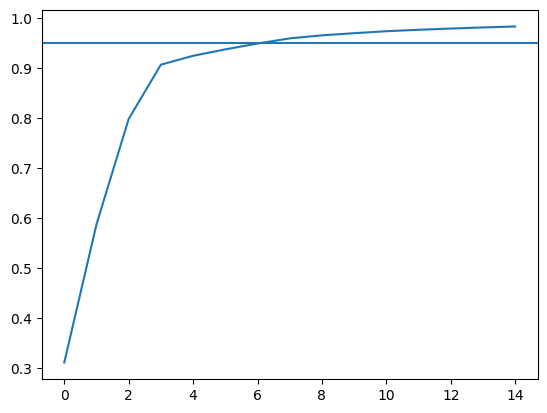

In [ ]:
init_dim_adjoint, init_dirs_adjoint, vars = get_components(pairs[-1][0].reshape(-1, n), center = False, return_var = True)
plt.plot(np.cumsum(vars / np.sum(vars))[:15])
plt.axhline(.95)
plt.show()

In [ ]:
proj = 0.
most_aligned = []
mags = []
for i in tqdm(range(len(pairs))):
    init_dim_adjoint, init_dirs_adjoint, vars = get_components(pairs[i][0].reshape(-1, n), center = False, return_var = True)
    proj_i = np.abs(np.array([[np.inner(dir1, dir2) for dir1 in init_dirs_adjoint] for dir2 in dirs_z0[-1][1]]))
    z_ind, a_ind = np.unravel_index(np.argmax(proj_i), proj_i.shape)
    most_aligned.append(z_ind)
    mags.append(vars[a_ind])

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


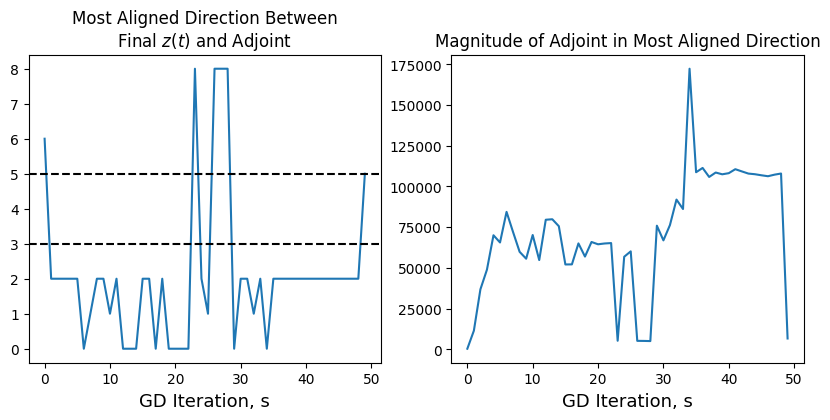

In [ ]:
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.plot(most_aligned)
plt.title('Most Aligned Direction Between\nFinal $z(t)$ and Adjoint')
plt.xlabel('GD Iteration, s', fontsize = 13)
plt.axhline(3, color = 'black', linestyle = 'dashed')
plt.axhline(5, color = 'black', linestyle = 'dashed')

plt.subplot(1,2,2)
plt.plot(mags)
plt.title('Magnitude of Adjoint in Most Aligned Direction')
plt.xlabel('GD Iteration, s', fontsize = 13)
plt.show()

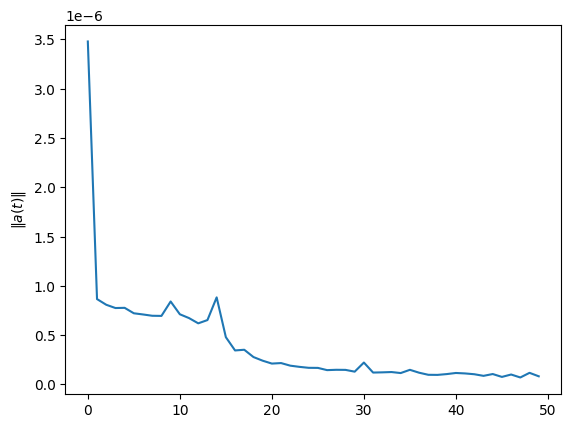

In [74]:
plt.plot([np.mean(np.linalg.norm(a0, axis=2), (0, 1)) for z0, a0 in pairs])
plt.ylabel('$\\|a(t)\\|$')
# plt.yscale('log')
plt.show()

In [14]:
# Evaluate the model on each subtask throughout training and see if the adjoints scales/alignments inform this accuracy.
grouped_losses = []
grouped_adj_norms = []
grouped_components = []
for ch in tqdm(checkpoints_all):
    _, hidden, adjoint, out, _, _, loss_unreduced = eval(ch) # Hidden shape is (B, T, H)
    loss_split = split_data(splits, loss_unreduced)
    adj_split = split_data(splits, adjoint)
    grouped_losses.append([loss_sub.mean().item() for loss_sub in loss_split.values()])
    grouped_adj_norms.append([np.linalg.norm(adj_sub,axis=2).mean((0,1)) for adj_sub in adj_split.values()])

    # Adjoint components
    grouped_components.append([get_components(adj_sub.reshape((-1, adj_sub.shape[-1])), k = 8) for adj_sub in adj_split.values()])

grouped_components = np.array(grouped_components) # [GD steps, 4 (task count), components, hidden size]

100%|██████████| 50/50 [00:09<00:00,  5.09it/s]


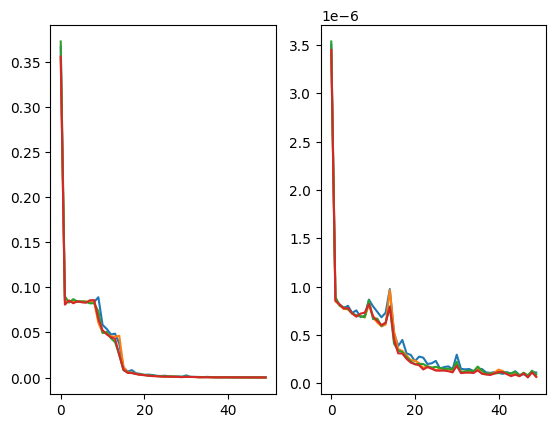

(50, 6, 8, 8)


<Figure size 640x480 with 0 Axes>

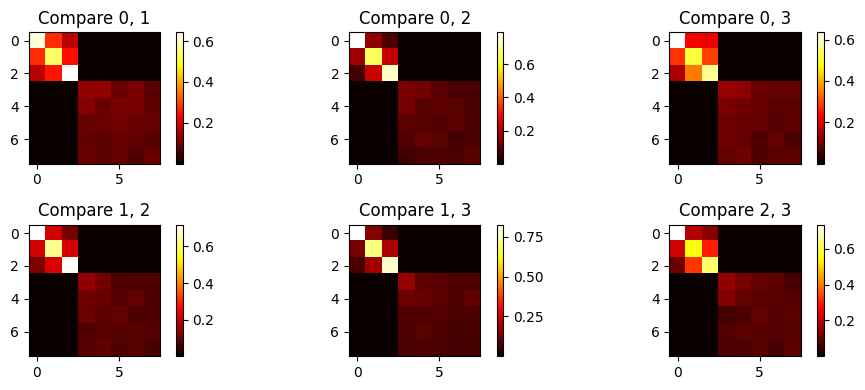

In [17]:
plt.subplot(1,2,1)
plt.plot(grouped_losses)
plt.subplot(1,2,2)
plt.plot(grouped_adj_norms)
plt.show()

plt.figure()
compare_inds = np.array([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]])
similarity = np.zeros((grouped_components.shape[0], compare_inds.shape[0], grouped_components.shape[2], grouped_components.shape[2])) + np.pi/2
print(similarity.shape)
for n in range(len(compare_inds)):
    for i in range(grouped_components.shape[2]):
        for j in range(grouped_components.shape[2]):
            task1, task2 = compare_inds[n] # Tasks to compare
            sim = np.abs(angle_between(grouped_components[:, task1, i], grouped_components[:, task2, j]) - np.pi/2) / (np.pi/2)
            # sim = np.abs((grouped_components[:, :, i, None, :] @ grouped_components[:, :, j, :, None])[:, :, 0, 0])
            similarity[:, n, i, j] = sim

plt.figure(figsize = (10, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(similarity.mean(0)[i], cmap = 'hot')
    plt.title(f'Compare {compare_inds[i,0]}, {compare_inds[i,1]}')
    plt.colorbar()
plt.tight_layout()
plt.show()